In [1]:
import scipy
import matplotlib
import numpy as np
import math
import pylab
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import colorbar
from matplotlib.patches import Ellipse
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterExponent
from matplotlib.ticker import LogLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from astropy.table import Table, vstack, join
from astropy.io import ascii, fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from collections import Counter
from matplotlib.lines import Line2D
import lmfit
from sklearn.linear_model import LinearRegression
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy import interpolate
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
pd.options.mode.copy_on_write = True
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.optimize import fsolve
import tensorflow as tf
from sklearn.metrics import r2_score

2025-03-11 21:02:36.072900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741741359.088386 2883450 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741741359.976600 2883450 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 21:02:46.349577: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## Common function for reading files and preprocessing data
#def read_fits_and_cut(input_file_name):
#    table = Table.read(input_file_name)
#    df = table.to_pandas()
#    df['id'] = df['id'].astype(str)
#    for column in df.columns:
#        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
#            df[column] = df[column].str.decode('utf-8')
#    df['g0'] = df['gpsf'] - df['a_g'] #a_g: galactic extinction in g band (HSC has girn-band)
#    df['i0'] = df['ipsf'] - df['a_i']
#    df['n0'] = df['npsf'] - df['a_n']
#    df['MGH'] = df['MGFE'] + df['FEH']
#    #df = df[(-0.0 < df['MGFEERR']) & (df['MGFEERR'] < 0.5)] #or df = df[(-0.80 <= df['MGFE']) & (df['MGFE'] < 1.20)]
#    return df

def read_fits_and_cut_plus(input_file_name):
    df = pd.read_csv(input_file_name)
    df['id'] = df['id'].astype(str)
    df.drop(['MASK','SLIT','B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
            'AGE','TEFFERR','LOGGERR','ALPHAFE', 'ALPHAFEERR','SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR'], axis=1, inplace=True)
    for column in df.columns:
        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
            df[column] = df[column].str.decode('utf-8')
    df = df[(-0.0 < df['MGFEERR']) & (df['MGFEERR'] < 0.5)]
    return df
    
def read_hsc(input_file_name):
    data = ascii.read(input_file_name,
        names=['id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr',
        'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n'])
    df = data.to_pandas()
    df['id'] = df['id'].astype(str)
    for column in df.columns:
        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
            df[column] = df[column].str.decode('utf-8')
    df['g0'] = df['gpsf'] - df['a_g']
    df['i0'] = df['ipsf'] - df['a_i']
    df['n0'] = df['npsf'] - df['a_n']
    return df

def read_hsc_members(input_file_name):
    df = pd.read_csv(input_file_name)
    df['id'] = df['id'].astype(str)
    for column in df.columns:
        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
            df[column] = df[column].str.decode('utf-8')
    return df

In [3]:
## Read HSC-DEIMOS files
fnx = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Fornax_HSC_DEIMOS_plus_w_age.csv')
scl = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Sculptor_HSC_DEIMOS_plus_w_age.csv')
umi = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Ursaminor_HSC_DEIMOS_plus_w_age.csv')
dra = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Draco_HSC_DEIMOS_plus_w_age.csv')
print(f'len(fnx) = {len(fnx)}') #485 -> 308
print(f'len(scl) = {len(scl)}') #405 -> 283
print(f'len(umi) = {len(umi)}') #263 -> 93
print(f'len(dra) = {len(dra)}') #168 -> 93

## Read whole HSC data
hsc_fnx = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/fornax_tpall3e_g24_radec_members_cut.csv')
hsc_scl = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/sculptor_tpall3e_g24_radec_members_cut.csv')
hsc_umi = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/ursaminor_tpall3e_g24_radec_members_cut.csv')
hsc_dra = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/draco_tpall3e_g24_radec_members_cut.csv')
print(f'len(hsc_fnx) = {len(hsc_fnx)}') #23089
print(f'len(hsc_scl) = {len(hsc_scl)}') #2137
print(f'len(hsc_umi) = {len(hsc_umi)}') #921
print(f'len(hsc_dra) = {len(hsc_dra)}') #478

# Define the distance modulus for each dataset from McConnachie (2012)
dm_values = {
    'fnx': 20.84,
    'scl': 19.67,
    'umi': 19.4,
    'dra': 19.4
}

# Define the datasets
datasets = {
    'fnx': [fnx, hsc_fnx],
    'scl': [scl, hsc_scl],
    'umi': [umi, hsc_umi],
    'dra': [dra, hsc_dra]
}

# Apply the distance modulus correction and store as G0
for key, dataset_list in datasets.items():
    dm = dm_values[key]
    for dataset in dataset_list:
        dataset['Mg0'] = dataset['g0'] - dm
        dataset['Mi0'] = dataset['i0'] - dm
        dataset['Mn0'] = dataset['n0'] - dm

xmin, xmax = 0.4, 2

Mg0_max = -0.20 ; Mn0_max = -0.30 ; Mi0_max = -1.18
fnx_mag = fnx[(xmin < fnx['Mg0']-fnx['Mi0']) & (fnx['Mg0']-fnx['Mi0'] < xmax) & (fnx['Mg0'] < Mg0_max) & (fnx['Mn0'] < Mn0_max) & (fnx['Mi0'] < Mi0_max)]
print('len(fnx_mag) =', len(fnx), '->', len(fnx_mag)) #308 -> 283
hsc_fnx_mag = hsc_fnx[(xmin < hsc_fnx['Mg0']-hsc_fnx['Mi0']) & (hsc_fnx['Mg0']-hsc_fnx['Mi0'] < xmax) & (hsc_fnx['Mg0'] < Mg0_max) & (hsc_fnx['Mn0'] < Mn0_max) & (hsc_fnx['Mi0'] < Mi0_max)]
print('len(hsc_fnx_mag) =', len(hsc_fnx), '->', len(hsc_fnx_mag)) #23089 -> 7251

Mg0_max = 0.18 ; Mn0_max = 0.08 ; Mi0_max = -0.70
scl_mag = scl[(xmin < scl['Mg0']-scl['Mi0']) & (scl['Mg0']-scl['Mi0'] < xmax) & (scl['Mg0'] < Mg0_max) & (scl['Mn0'] < Mn0_max) & (scl['Mi0'] < Mi0_max)]
print('len(scl_mag) =', len(scl), '->', len(scl_mag)) #283 -> 280
hsc_scl_mag = hsc_scl[(xmin < hsc_scl['Mg0']-hsc_scl['Mi0']) & (hsc_scl['Mg0']-hsc_scl['Mi0'] < xmax) & (hsc_scl['Mg0'] < Mg0_max) & (hsc_scl['Mn0'] < Mn0_max) & (hsc_scl['Mi0'] < Mi0_max)]
print('len(hsc_scl_mag) =', len(hsc_scl), '->', len(hsc_scl_mag)) #2137 -> 1132

Mg0_max = 1.00 ; Mn0_max = 0.85 ; Mi0_max = 0.15
umi_mag = umi[(xmin < umi['Mg0']-umi['Mi0']) & (umi['Mg0']-umi['Mi0'] < xmax) & (umi['Mg0'] < Mg0_max) & (umi['Mn0'] < Mn0_max) & (umi['Mi0'] < Mi0_max)]
print('len(umi_mag) =', len(umi), '->', len(umi_mag)) #93 -> 88
hsc_umi_mag = hsc_umi[(xmin < hsc_umi['Mg0']-hsc_umi['Mi0']) & (hsc_umi['Mg0']-hsc_umi['Mi0'] < xmax) & (hsc_umi['Mg0'] < Mg0_max) & (hsc_umi['Mn0'] < Mn0_max) & (hsc_umi['Mi0'] < Mi0_max)]
print('len(hsc_umi_mag) =', len(hsc_umi), '->', len(hsc_umi_mag)) #921 -> 593

Mg0_max = 0.65 ; Mn0_max = 0.50 ; Mi0_max = -0.20
dra_mag = dra[(xmin < dra['Mg0']-dra['Mi0']) & (dra['Mg0']-dra['Mi0'] < xmax) & (dra['Mg0'] < Mg0_max) & (dra['Mn0'] < Mn0_max) & (dra['Mi0'] < Mi0_max)]
print('len(dra_mag) =', len(dra), '->', len(dra_mag)) #93 -> 90
hsc_dra_mag = hsc_dra[(xmin < hsc_dra['Mg0']-hsc_dra['Mi0']) & (hsc_dra['Mg0']-hsc_dra['Mi0'] < xmax) & (hsc_dra['Mg0'] < Mg0_max) & (hsc_dra['Mn0'] < Mn0_max) & (hsc_dra['Mi0'] < Mi0_max)]
print('len(hsc_dra_mag) =', len(hsc_dra), '->', len(hsc_dra_mag)) #478 -> 342

umi_mag = pd.concat([umi_mag.copy()] * 3, ignore_index=True)
dra_mag = pd.concat([dra_mag.copy()] * 3, ignore_index=True)

# Combine DEIMOS
frame = [fnx_mag, scl_mag, umi_mag, dra_mag]
df_mag = pd.concat(frame, ignore_index=True)
print('len(df_mag) =', len(df_mag)) #741
print(Counter(df_mag['DSPH'])) #Counter({'for': 283, 'scl': 280, 'dra': 90, 'umi': 88})

# Combine HSC
frame = [hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag]
hsc_df_mag = pd.concat(frame, ignore_index=True)
print('len(hsc_df_mag) =', len(hsc_df_mag)) #9318
print(Counter(hsc_df_mag['name'])) #Counter({'for': 7251, 'scl': 1132, 'umi': 593, 'dra': 342})

len(fnx) = 308
len(scl) = 283
len(umi) = 93
len(dra) = 93
len(hsc_fnx) = 23089
len(hsc_scl) = 2137
len(hsc_umi) = 921
len(hsc_dra) = 478
len(fnx_mag) = 308 -> 283
len(hsc_fnx_mag) = 23089 -> 7251
len(scl_mag) = 283 -> 280
len(hsc_scl_mag) = 2137 -> 1132
len(umi_mag) = 93 -> 88
len(hsc_umi_mag) = 921 -> 593
len(dra_mag) = 93 -> 90
len(hsc_dra_mag) = 478 -> 342
len(df_mag) = 1097
Counter({'for': 283, 'scl': 280, 'dra': 270, 'umi': 264})
len(hsc_df_mag) = 9318
Counter({'for': 7251, 'scl': 1132, 'umi': 593, 'dra': 342})


# ANN using Tensorflow-Keras

/afs/crc.nd.edu/user/j/jhong5/.local/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-11 21:19:30.415005: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,255,170 (20.05 MB)

 Trainable params: 5,255,170 (20.05 MB)

 Non-trainable params: 0 (0.00 B)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
          loss       mae       mse  val_loss   val_mae   val_mse  epoch
495  0.064003  0.188787  0.064003  0.058153  0.180202  0.058153    495
496  0.061038  0.183280  0.061038  0.057661  0.181934  0.057661    496
497  0.061412  0.185671  0.061412  0.054341  0.175224  0.054341    497
498  0.063655  0.189126  0.063655  0.062015  0.187316  0.062015    498
499  0.061651  0.184410  0.061651  0.059606  0.187504  0.059606    499


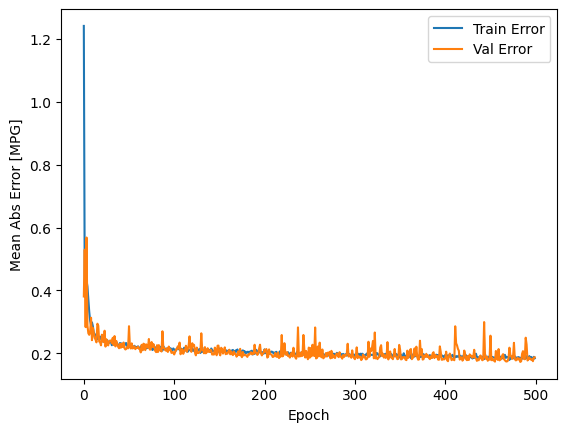

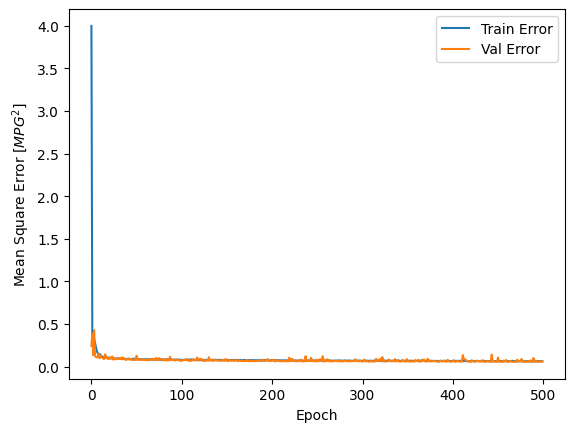

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Test R² FEH: 0.806616432788651
Test R² MGH: 0.529107935326188
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Training R² FEH: 0.8150699771637381
Training R² MGH: 0.5564508616053905
292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
CPU times: user 4h 37min 46s, sys: 1h 58min 3s, total: 6h 35min 50s
Wall time: 18min 48s


In [4]:
%%time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

#Do one-hot incoding using pd.get_dummies
df_mag['DSPH_original'] = df_mag['DSPH']
df_mag = pd.get_dummies(df_mag, columns=['DSPH'])
df_mag['galaxy_id'] = (
    0 * df_mag['DSPH_for'] +
    1 * df_mag['DSPH_scl'] +
    2 * df_mag['DSPH_umi'] +
    3 * df_mag['DSPH_dra']
)
df_mag.rename(columns = {'DSPH_original':'DSPH'}, inplace=True)
df_mag['Mg0_Mi0'] = df_mag['Mg0'] - df_mag['Mi0']
df_mag['Mg0_Mn0'] = df_mag['Mg0'] - df_mag['Mn0']

indices = df_mag.index

train_dataset, test_dataset = train_test_split(df_mag, test_size=0.2, random_state=42)

# Try using raw mags as input params
# Try using pooling data 

def build_model_ann():
    model = keras.Sequential([
        keras.layers.Dense(1024, activation='relu', input_shape=(4,)),
        keras.layers.Dense(1024, activation='relu'),
        Dropout(0.2), #prevent overfitting
        keras.layers.Dense(1024, activation='relu'),
        Dropout(0.2),
        keras.layers.Dense(1024, activation='relu'),
        Dropout(0.2),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(2)  #FEH and MGH 
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

model_ann = build_model_ann()
model_ann.summary()

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 500 #5000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=500)

#history = model_ann.fit(train_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']],
history = model_ann.fit(train_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']],
                    train_dataset[['FEH', 'MGH']],
                    epochs=EPOCHS, validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])
#model_ann.save("model_ann.h5")

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print('\n', hist.tail())

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()

plot_history(history)

# Perform Predictions
#test_predictions = model_ann.predict(test_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])
test_predictions = model_ann.predict(test_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']])
test_dataset['FEH_phot_ann'], test_dataset['MGH_phot_ann'] = test_predictions[:, 0], test_predictions[:, 1]
test_dataset['MGFE_phot_ann'] = test_dataset['MGH_phot_ann'] - test_dataset['FEH_phot_ann']
test_r2_feh = r2_score(test_dataset['FEH'], test_dataset['FEH_phot_ann'])
test_r2_mgh = r2_score(test_dataset['MGH'], test_dataset['MGH_phot_ann'])
print("Test R² FEH:", test_r2_feh) #0.806616432788651
print("Test R² MGH:", test_r2_mgh) #0.529107935326188

#train_predictions = model_ann.predict(train_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])
train_predictions = model_ann.predict(train_dataset[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']])
train_dataset['FEH_phot_ann'], train_dataset['MGH_phot_ann'] = train_predictions[:, 0], train_predictions[:, 1]
train_dataset['MGFE_phot_ann'] = train_dataset['MGH_phot_ann'] - train_dataset['FEH_phot_ann']
train_r2_feh = r2_score(train_dataset['FEH'], train_dataset['FEH_phot_ann'])
train_r2_mgh = r2_score(train_dataset['MGH'], train_dataset['MGH_phot_ann'])
print("Training R² FEH:", train_r2_feh) #0.8150699771637381
print("Training R² MGH:", train_r2_mgh) #5564508616053905

hsc_df_mag['name_original'] = hsc_df_mag['name']
hsc_df_mag = pd.get_dummies(hsc_df_mag, columns=['name'])
hsc_df_mag['galaxy_id'] = (
    0 * hsc_df_mag['name_for'] +
    1 * hsc_df_mag['name_scl'] +
    2 * hsc_df_mag['name_umi'] +
    3 * hsc_df_mag['name_dra']
)
hsc_df_mag.rename(columns = {'name_original':'name'}, inplace=True)
hsc_df_mag['Mg0_Mi0'] = hsc_df_mag['Mg0'] - hsc_df_mag['Mi0']
hsc_df_mag['Mg0_Mn0'] = hsc_df_mag['Mg0'] - hsc_df_mag['Mn0']

#hsc_predictions = model_ann.predict(hsc_df_mag[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])
hsc_predictions = model_ann.predict(hsc_df_mag[['Mg0', 'Mi0', 'Mn0', 'galaxy_id']])
hsc_df_mag['FEH_phot_ann'], hsc_df_mag['MGH_phot_ann'] = hsc_predictions[:, 0], hsc_predictions[:, 1]
hsc_df_mag['MGFE_phot_ann'] = hsc_df_mag['MGH_phot_ann'] - hsc_df_mag['FEH_phot_ann']

#Wall time: 19min 7s

In [5]:
train_fnx = train_dataset[train_dataset['galaxy_id'] == 0]
train_scl = train_dataset[train_dataset['galaxy_id'] == 1]
train_umi = train_dataset[train_dataset['galaxy_id'] == 2]
train_dra = train_dataset[train_dataset['galaxy_id'] == 3]

test_fnx = test_dataset[test_dataset['galaxy_id'] == 0]
test_scl = test_dataset[test_dataset['galaxy_id'] == 1]
test_umi = test_dataset[test_dataset['galaxy_id'] == 2]
test_dra = test_dataset[test_dataset['galaxy_id'] == 3]

hsc_fnx_mag = hsc_df_mag[hsc_df_mag['name'] == 'for']
hsc_scl_mag = hsc_df_mag[hsc_df_mag['name'] == 'scl']
hsc_umi_mag = hsc_df_mag[hsc_df_mag['name'] == 'umi']
hsc_dra_mag = hsc_df_mag[hsc_df_mag['name'] == 'dra']

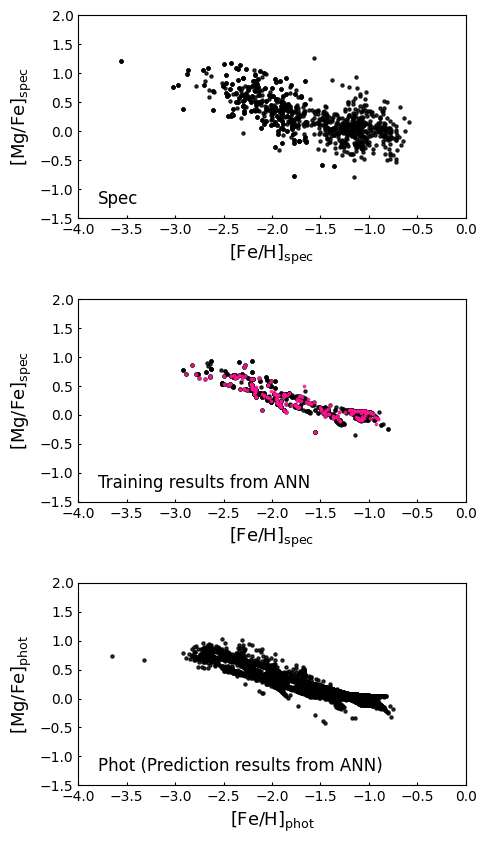

In [6]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(5,10), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 5 ; alpha = 0.8

# Spectroscopy
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, 0])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Spec', ha='left', va='bottom', transform=ax0.transAxes, color='k', size=12)

# Training
ax1.scatter(train_fnx['FEH_phot_ann'], train_fnx['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(train_scl['FEH_phot_ann'], train_scl['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(train_umi['FEH_phot_ann'], train_umi['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dra['FEH_phot_ann'], train_dra['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(test_fnx['FEH_phot_ann'], test_fnx['MGFE_phot_ann'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_scl['FEH_phot_ann'], test_scl['MGFE_phot_ann'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_umi['FEH_phot_ann'], test_umi['MGFE_phot_ann'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_dra['FEH_phot_ann'], test_dra['MGFE_phot_ann'], s=3, alpha=alpha, color='deeppink')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax1.set_xlim([-4, 0])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Training results from ANN', ha='left', va='bottom', transform=ax1.transAxes, color='k', size=12)

# Photometry
ax2.scatter(hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax2.set_xlim([-4, 0])
ax2.set_ylim([-1.5, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.05, 0.05, 'Phot (Prediction results from ANN)', ha='left', va='bottom', transform=ax2.transAxes, color='k', size=12)

plt.savefig('feh_mgfe_phot_spec_scatter_ANN_tensorflow_keras.png', bbox_inches='tight')

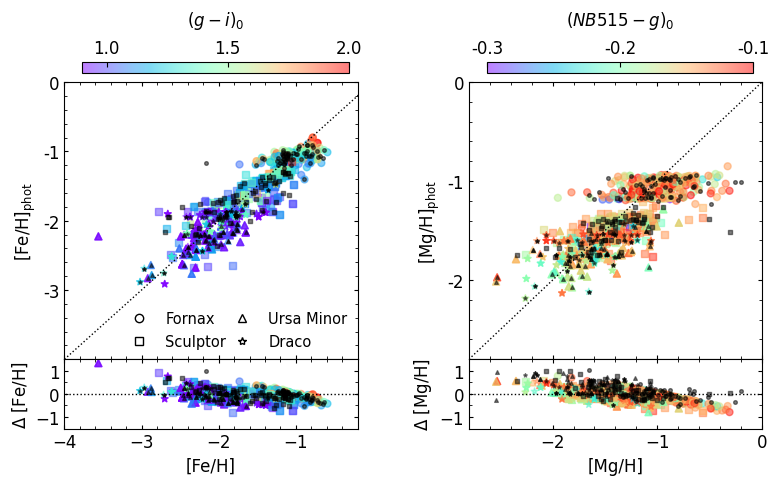

In [7]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 4.5), gridspec_kw={'wspace':0.38, 'hspace':0, 'height_ratios': [1, 0.25]})
s = 25 ; alpha = 0.5
xmin, xmax = -4, -0.2
vmin, vmax = 0.9, 2
color = 'deeppink'
markers = ['o', 's', '^', '*']

# Training
# [Fe/H]
ax0.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax0.scatter(train_fnx['FEH'], train_fnx['FEH_phot_ann'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax0.scatter(train_scl['FEH'], train_scl['FEH_phot_ann'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax0.scatter(train_umi['FEH'], train_umi['FEH_phot_ann'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax0.scatter(train_dra['FEH'], train_dra['FEH_phot_ann'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax0.scatter(test_fnx['FEH'], test_fnx['FEH_phot_ann'], s=7, alpha=0.5, marker=markers[0], color='black')
ax0.scatter(test_scl['FEH'], test_scl['FEH_phot_ann'], s=7, alpha=0.5, marker=markers[1], color='black')
ax0.scatter(test_umi['FEH'], test_umi['FEH_phot_ann'], s=7, alpha=0.5, marker=markers[2], color='black')
ax0.scatter(test_dra['FEH'], test_dra['FEH_phot_ann'], s=7, alpha=0.5, marker=markers[3], color='black')

custom_legend = [
    Line2D([0], [0], linestyle='None', marker=markers[0], color='k', markerfacecolor='w', markersize=6, label='Fornax'),
    Line2D([0], [0], linestyle='None', marker=markers[1], color='k', markerfacecolor='w', markersize=6, label='Sculptor'),
    Line2D([0], [0], linestyle='None', marker=markers[2], color='k', markerfacecolor='w', markersize=6, label='Ursa Minor'),
    Line2D([0], [0], linestyle='None', marker=markers[3], color='k', markerfacecolor='w', markersize=6, label='Draco'),
]
legend = ax0.legend(handles=custom_legend, fontsize=10.5, framealpha=0, ncol=2, columnspacing=0.1)
legend.set_bbox_to_anchor((0.16, 0.12, 0.3, 0.1), transform=ax0.transAxes)
ax0.set_xlabel('')
ax0.set_ylabel('[Fe/H]$_\mathrm{phot}$', size=12)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([xmin, xmax])
ax0.set_xticklabels('')
ax0.set_yticks([-3, -2, -1, 0])
ax0.set_yticklabels(['-3', '-2', '-1', '0'])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator(5))
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax0.text(0.05, 0.96, f'Training (N={len(train_FEH)}, RMSE={train_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
#ax0.text(0.05, 0.88, f'Test (N={len(test_FEH)}, RMSE={test_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.02, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(g - i)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([1.0, 1.5, 2.0])
cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])
#m_train, b_train = np.polyfit(train_FEH['FEH'], train_FEH['FEH_phot_ann'], 1)
#ax0.plot(np.linspace(xmin, xmax, 100), m_train * np.linspace(xmin, xmax, 100) + b_train, color='black', linestyle='-', linewidth=1.5, label='Train Fit')
#print('m_train =', m_train)

ax2.axhline(0, xmin, xmax+2, color='k', linewidth=1, linestyle=':')
ax2.scatter(train_fnx['FEH'], train_fnx['FEH_phot_ann']-train_fnx['FEH'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax2.scatter(train_scl['FEH'], train_scl['FEH_phot_ann']-train_scl['FEH'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax2.scatter(train_umi['FEH'], train_umi['FEH_phot_ann']-train_umi['FEH'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax2.scatter(train_dra['FEH'], train_dra['FEH_phot_ann']-train_dra['FEH'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax2.scatter(test_fnx['FEH'], test_fnx['FEH_phot_ann']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax2.scatter(test_scl['FEH'], test_scl['FEH_phot_ann']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax2.scatter(test_umi['FEH'], test_umi['FEH_phot_ann']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax2.scatter(test_dra['FEH'], test_dra['FEH_phot_ann']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax2.set_xlabel('[Fe/H]', size=12)
ax2.set_ylabel('$\Delta$ [Fe/H]', size=12)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([-1.5, 1.5])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)


# Test
# [Mg/H]
xmin, xmax = -2.8, 0
vmin, vmax = -0.3, -0.1
ax1.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax1.scatter(train_fnx['MGH'], train_fnx['MGH_phot_ann'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax1.scatter(train_scl['MGH'], train_scl['MGH_phot_ann'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax1.scatter(train_umi['MGH'], train_umi['MGH_phot_ann'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax1.scatter(train_dra['MGH'], train_dra['MGH_phot_ann'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax1.scatter(test_fnx['MGH'], test_fnx['MGH_phot_ann'], s=7, alpha=0.5, marker=markers[0], color='black')
ax1.scatter(test_scl['MGH'], test_scl['MGH_phot_ann'], s=7, alpha=0.5, marker=markers[1], color='black')
ax1.scatter(test_umi['MGH'], test_umi['MGH_phot_ann'], s=7, alpha=0.5, marker=markers[2], color='black')
ax1.scatter(test_dra['MGH'], test_dra['MGH_phot_ann'], s=7, alpha=0.5, marker=markers[3], color='black')

ax1.set_xlabel('')
ax1.set_ylabel('[Mg/H]$_\mathrm{phot}$', size=12)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([xmin, xmax])
ax1.set_xticklabels('')
ax1.set_yticks([-2, -1, 0])
ax1.set_yticklabels(['-2', '-1', '0'])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax1.text(0.05, 0.96, f'Training (N={len(train_MGH)}, RMSE={train_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
#ax1.text(0.05, 0.88, f'Test (N={len(test_MGH)}, RMSE={test_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.02, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(NB515 - g)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([-0.3, -0.2, -0.1])
cbar.ax.set_xticklabels(['-0.3', '-0.2', '-0.1'])
#m_test, b_test = np.polyfit(test_FEH['FEH'], test_FEH['FEH_phot_ann'], 1)
#ax1.plot(np.linspace(xmin, xmax, 100), m_test * np.linspace(xmin, xmax, 100) + b_test, color=color, linestyle='-', linewidth=1.5, label='Test Fit')
#print('m_test =', m_test)

ax3.axhline(0, xmin, xmax+1, color='k', linewidth=1, linestyle=':')
ax3.scatter(train_fnx['MGH'], train_fnx['MGH_phot_ann']-train_fnx['MGH'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax3.scatter(train_scl['MGH'], train_scl['MGH_phot_ann']-train_scl['MGH'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax3.scatter(train_umi['MGH'], train_umi['MGH_phot_ann']-train_umi['MGH'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax3.scatter(train_dra['MGH'], train_dra['MGH_phot_ann']-train_dra['MGH'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax3.scatter(test_fnx['MGH'], test_fnx['MGH_phot_ann']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax3.scatter(test_scl['MGH'], test_scl['MGH_phot_ann']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax3.scatter(test_umi['MGH'], test_umi['MGH_phot_ann']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax3.scatter(test_dra['MGH'], test_dra['MGH_phot_ann']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax3.set_xlabel('[Mg/H]', size=12)
ax3.set_ylabel('$\Delta$ [Mg/H]', size=12)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([-1.5, 1.5])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

plt.savefig('feh_mgh_training_test_residuals_ANN_tensorflow_keras.png', bbox_inches='tight')

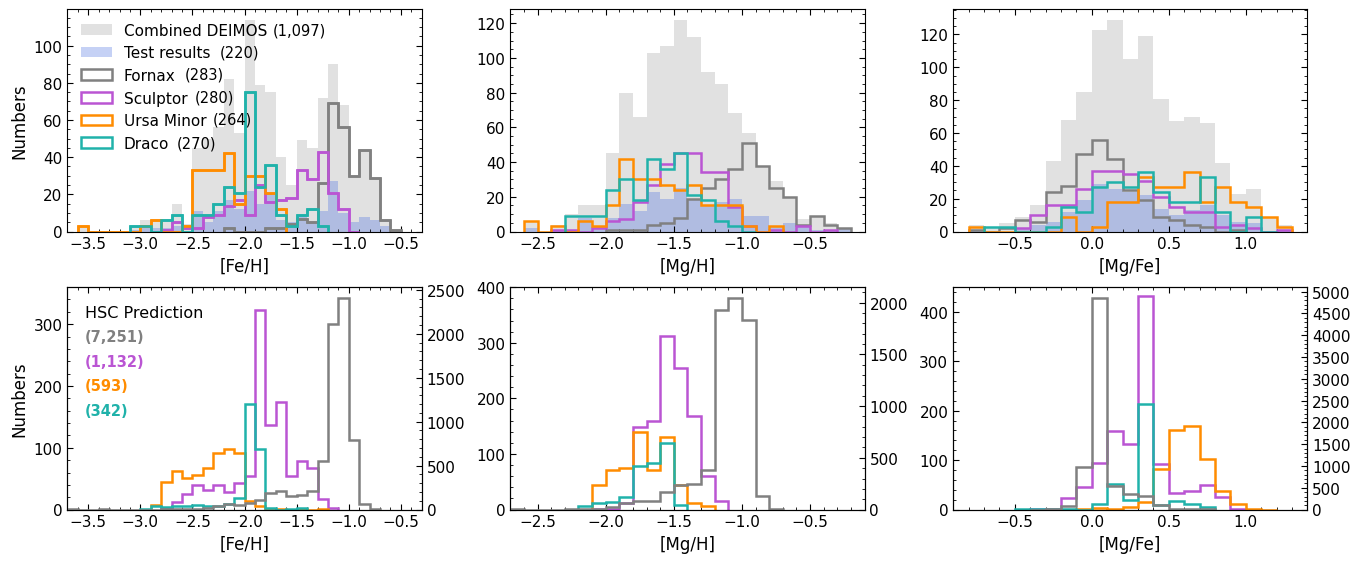

In [8]:
def plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    for data, color in zip(data_list, colors):
        ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                histtype='step', linestyle=linestyle, color=color, linewidth=1.8, alpha=alpha)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    if show_legend:
        for data, label, color in zip(data_list, labels, colors):
            ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                    histtype='step', linestyle=linestyle, color=color, label=label, linewidth=1.8, alpha=alpha)
        ax.legend(loc='upper left', frameon=False, fontsize=11)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)

def plot_with_twinx(ax_twin, ax, twin_data, data_list, twin_label, labels, twin_color, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    ax_twin.hist(twin_data, bins=np.arange(np.floor(np.min(twin_data) / bins_width) * bins_width,
                                     np.ceil(np.max(twin_data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                 histtype='step', linestyle=linestyle, color=twin_color, label=twin_label, linewidth=1.8, alpha=alpha)
    plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width, show_legend, linestyle)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax_twin.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax_twin.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax_twin.yaxis.set_minor_locator(MultipleLocator(100))
    ax_twin.yaxis.set_major_locator(MultipleLocator(500))
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_twin, labels_twin = ax_twin.get_legend_handles_labels()
        ax.legend(handles_twin + handles, labels_twin + labels, loc='upper left', frameon=False, fontsize=10)



# Set up the figure and axes
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 6.5), gridspec_kw={'wspace': 0.25, 'hspace': 0.25})
bins_width = 0.1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']
alpha = 1

# 1st row 
ax0.hist(df_mag['FEH'], bins=np.arange(np.floor(np.min(df_mag['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2, label='Combined DEIMOS')
ax0.hist(test_dataset['FEH'], bins=np.arange(np.floor(np.min(test_dataset['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3, label='Test results')
plot_histogram(ax0, [fnx_mag['FEH'], scl_mag['FEH'], umi_mag['FEH'], dra_mag['FEH']], labels, colors, alpha, '[Fe/H]', 'Numbers')
ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_xlim([-3.7, -0.3])
ax0.text(0.58, 0.94, '({0:,.0f})'.format(len(df_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.43, 0.84, '({0:,.0f})'.format(len(test_dataset['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.33, 0.74, '({0:,.0f})'.format(len(fnx_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.36, 0.64, '({0:,.0f})'.format(len(scl_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.41, 0.54, '({0:,.0f})'.format(len(umi_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.31, 0.43, '({0:,.0f})'.format(len(dra_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)

ax1.hist(df_mag['MGH'], bins=np.arange(np.floor(np.min(df_mag['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax1.hist(test_dataset['MGH'], bins=np.arange(np.floor(np.min(test_dataset['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax1, [fnx_mag['MGH'], scl_mag['MGH'], umi_mag['MGH'], dra_mag['MGH']], labels, colors, alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax1.set_xlim([-2.7, -0.1])

ax2.hist(df_mag['MGFE'], bins=np.arange(np.floor(np.min(df_mag['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax2.hist(test_dataset['MGFE'], bins=np.arange(np.floor(np.min(test_dataset['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax2, [fnx_mag['MGFE'], scl_mag['MGFE'], umi_mag['MGFE'], dra_mag['MGFE']], labels, colors, alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax2.set_xlim([-0.9, 1.4])

# 2nd row
plot_with_twinx(ax3.twinx(), ax3,
                hsc_fnx_mag['FEH_phot_ann'], [hsc_scl_mag['FEH_phot_ann'], hsc_umi_mag['FEH_phot_ann'], hsc_dra_mag['FEH_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Fe/H]', 'Numbers', show_legend=False)
ax3.set_xlim([-3.7, -0.3])
ax3.set_ylim([0, 360])
ax3.text(0.05, 0.92, 'HSC Prediction', ha='left', va='top', transform=ax3.transAxes, size=11.5)
ax3.text(0.05, 0.81, '({0:,.0f})'.format(len(hsc_fnx_mag['FEH_phot_ann'])), ha='left', va='top', color=colors[0], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.70, '({0:,.0f})'.format(len(hsc_scl_mag['FEH_phot_ann'])), ha='left', va='top', color=colors[1], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.59, '({0:,.0f})'.format(len(hsc_umi_mag['FEH_phot_ann'])), ha='left', va='top', color=colors[2], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.48, '({0:,.0f})'.format(len(hsc_dra_mag['FEH_phot_ann'])), ha='left', va='top', color=colors[3], size=10.5, transform=ax3.transAxes, fontweight='bold')

plot_with_twinx(ax4.twinx(), ax4, 
                hsc_fnx_mag['MGH_phot_ann'], [hsc_scl_mag['MGH_phot_ann'], hsc_umi_mag['MGH_phot_ann'], hsc_dra_mag['MGH_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax4.set_xlim([-2.7, -0.1])
ax4.set_ylim([0, 400])

plot_with_twinx(ax5.twinx(), ax5, 
                hsc_fnx_mag['MGFE_phot_ann'], [hsc_scl_mag['MGFE_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], hsc_dra_mag['MGFE_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax5.set_xlim([-0.9, 1.4])
ax5.set_ylim([0, 450])

for ax in [ax1, ax2, ax4, ax5]:
    ax.set_ylabel('')

plt.savefig('feh_mgh_mgfe_distribution_ANN_tensorflow_keras.png', bbox_inches='tight')

In [9]:
data = {
    'FEH': [
        f"{np.mean(fnx_mag['FEH']):.2f} ± {np.std(fnx_mag['FEH']):.2f}",
        f"{np.mean(scl_mag['FEH']):.2f} ± {np.std(scl_mag['FEH']):.2f}",
        f"{np.mean(umi_mag['FEH']):.2f} ± {np.std(umi_mag['FEH']):.2f}",
        f"{np.mean(dra_mag['FEH']):.2f} ± {np.std(dra_mag['FEH']):.2f}",
        f"{np.mean(hsc_fnx_mag['FEH_phot_ann']):.2f} ± {np.std(hsc_fnx_mag['FEH_phot_ann']):.2f}",
        f"{np.mean(hsc_scl_mag['FEH_phot_ann']):.2f} ± {np.std(hsc_scl_mag['FEH_phot_ann']):.2f}",
        f"{np.mean(hsc_umi_mag['FEH_phot_ann']):.2f} ± {np.std(hsc_umi_mag['FEH_phot_ann']):.2f}",
        f"{np.mean(hsc_dra_mag['FEH_phot_ann']):.2f} ± {np.std(hsc_dra_mag['FEH_phot_ann']):.2f}"
    ],
    'MGH': [
        f"{np.mean(fnx_mag['MGH']):.2f} ± {np.std(fnx_mag['MGH']):.2f}",
        f"{np.mean(scl_mag['MGH']):.2f} ± {np.std(scl_mag['MGH']):.2f}",
        f"{np.mean(umi_mag['MGH']):.2f} ± {np.std(umi_mag['MGH']):.2f}",
        f"{np.mean(dra_mag['MGH']):.2f} ± {np.std(dra_mag['MGH']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGH_phot_ann']):.2f} ± {np.std(hsc_fnx_mag['MGH_phot_ann']):.2f}",
        f"{np.mean(hsc_scl_mag['MGH_phot_ann']):.2f} ± {np.std(hsc_scl_mag['MGH_phot_ann']):.2f}",
        f"{np.mean(hsc_umi_mag['MGH_phot_ann']):.2f} ± {np.std(hsc_umi_mag['MGH_phot_ann']):.2f}",
        f"{np.mean(hsc_dra_mag['MGH_phot_ann']):.2f} ± {np.std(hsc_dra_mag['MGH_phot_ann']):.2f}"
    ],
    'MGFE': [
        f"{np.mean(fnx_mag['MGFE']):.2f} ± {np.std(fnx_mag['MGFE']):.2f}",
        f"{np.mean(scl_mag['MGFE']):.2f} ± {np.std(scl_mag['MGFE']):.2f}",
        f"{np.mean(umi_mag['MGFE']):.2f} ± {np.std(umi_mag['MGFE']):.2f}",
        f"{np.mean(dra_mag['MGFE']):.2f} ± {np.std(dra_mag['MGFE']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGFE_phot_ann']):.2f} ± {np.std(hsc_fnx_mag['MGFE_phot_ann']):.2f}",
        f"{np.mean(hsc_scl_mag['MGFE_phot_ann']):.2f} ± {np.std(hsc_scl_mag['MGFE_phot_ann']):.2f}",
        f"{np.mean(hsc_umi_mag['MGFE_phot_ann']):.2f} ± {np.std(hsc_umi_mag['MGFE_phot_ann']):.2f}",
        f"{np.mean(hsc_dra_mag['MGFE_phot_ann']):.2f} ± {np.std(hsc_dra_mag['MGFE_phot_ann']):.2f}"
    ]
}

index = [
    'fnx_mag', 'scl_mag', 'umi_mag', 'dra_mag',
    'hsc_fnx_mag', 'hsc_scl_mag', 'hsc_umi_mag', 'hsc_dra_mag'
]

df = pd.DataFrame(data, index=index)

df.to_csv('feh_mgh_mgfe_mean_std_ANN_tensorflow_keras.csv', index=False)

# ANN using PyTorch

ANNModel(
  (fc1): Linear(in_features=4, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=1024, bias=True)
  (fc7): Linear(in_features=1024, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 0/500:
....................................................................................................
Epoch 100/500:
....................................................................................................
Epoch 200/500:
....................................................................................................
Epoch 300/500:
....................................................................................................
Epoch 400/500:
.........................

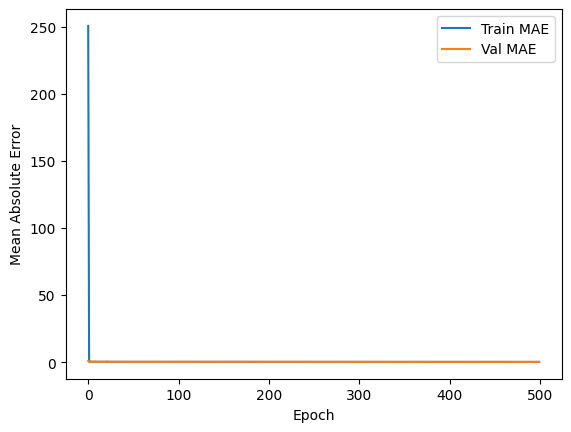

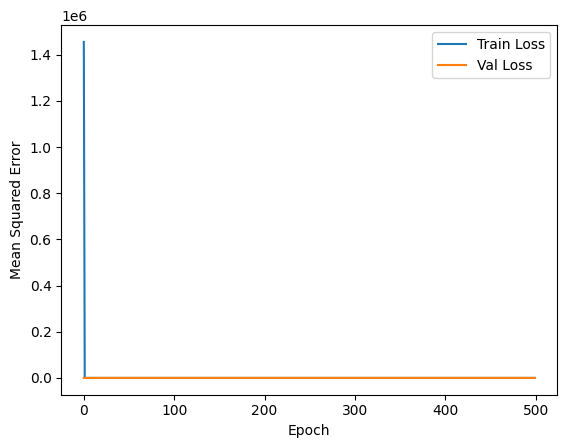

Test R² FEH: 0.815008339307173
Test R² MGH: 0.5254389210725939
Train R² FEH: 0.8480162867595313
Train R² MGH: 0.5901053333337637
CPU times: user 1h 2min 40s, sys: 50.6 s, total: 1h 3min 31s
Wall time: 1h 4min 23s


In [10]:
%%time
import torch
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import r2_score

# 1. Split the data
train_df_full, test_df = train_test_split(df_mag, test_size=0.2, random_state=42)
# Set the validation (training) sample
train_df, val_df = train_test_split(train_df_full, test_size=0.2, random_state=42)

# Input features
feature_cols = ['Mg0', 'Mi0', 'Mn0', 'galaxy_id']
target_cols  = ['FEH', 'MGH']

# Conversion Tensor (dtype: float32)
x_train = torch.tensor(train_df[feature_cols].values, dtype=torch.float32)
y_train = torch.tensor(train_df[target_cols].values, dtype=torch.float32)
x_val   = torch.tensor(val_df[feature_cols].values, dtype=torch.float32)
y_val   = torch.tensor(val_df[target_cols].values, dtype=torch.float32)
x_test  = torch.tensor(test_df[feature_cols].values, dtype=torch.float32)

# Make TensorDataset and DataLoader
batch_size = 32
train_data = TensorDataset(x_train, y_train)
val_data   = TensorDataset(x_val, y_val)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# 2. Define model
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(4, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 1024)
        self.fc6 = nn.Linear(1024, 1024)
        self.fc7 = nn.Linear(1024, 2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x

model = ANNModel()
print(model)

# 3. Set the optimizer and loss function
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 4. Learning loop with Early Stopping
EPOCHS = 500
patience = 500
best_val_loss = float('inf')
epochs_no_improve = 0

# Make lists to save the learning/validation/MAE
train_losses, val_losses = [], []
train_mae, val_mae = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_mae += torch.mean(torch.abs(outputs - targets)).item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_mae = running_mae / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_mae.append(epoch_mae)
    
    # Validation 단계
    model.eval()
    val_running_loss = 0.0
    val_running_mae = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * inputs.size(0)
            val_running_mae += torch.mean(torch.abs(outputs - targets)).item() * inputs.size(0)
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_mae = val_running_mae / len(val_loader.dataset)
    val_losses.append(val_epoch_loss)
    val_mae.append(val_epoch_mae)
    
    # Go to the new line every 100 epoch
    if epoch % 100 == 0:
        print(f"\nEpoch {epoch}/{EPOCHS}:")
    print('.', end='')
    
    # Early Stopping: Validation loss가 개선되면 모델 저장
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
    if epochs_no_improve >= patience:
        print("\nEarly stopping at epoch", epoch)
        break

print('\nTraining complete.')

# 5. Visualize learning process
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Val MAE')
plt.legend()
plt.show()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

# 6. Get prediction
# Load the best model parameters in modeling
model.load_state_dict(best_model_state)
model.eval()

with torch.no_grad():
    # Predict test sample
    test_preds = model(x_test).numpy()
    # Predict training sample
    x_train_full = torch.tensor(train_df_full[feature_cols].values, dtype=torch.float32)
    train_preds = model(x_train_full).numpy()
    # Predict HSC sample
    x_hsc = torch.tensor(hsc_df_mag[feature_cols].values, dtype=torch.float32)
    hsc_preds = model(x_hsc).numpy()

# Save the prediction to the dataframe
test_df['FEH_phot_ann_pytorch'] = test_preds[:, 0]
test_df['MGH_phot_ann_pytorch'] = test_preds[:, 1]
test_df['MGFE_phot_ann_pytorch'] = test_df['MGH_phot_ann_pytorch'] - test_df['FEH_phot_ann_pytorch']
test_r2_feh = r2_score(test_df['FEH'], test_df['FEH_phot_ann_pytorch'])
test_r2_mgh = r2_score(test_df['MGH'], test_df['MGH_phot_ann_pytorch'])
print("Test R² FEH:", test_r2_feh) #0.815008339307173
print("Test R² MGH:", test_r2_mgh) #0.5254389210725939

train_df_full['FEH_phot_ann_pytorch'] = train_preds[:, 0]
train_df_full['MGH_phot_ann_pytorch'] = train_preds[:, 1]
train_df_full['MGFE_phot_ann_pytorch'] = train_df_full['MGH_phot_ann_pytorch'] - train_df_full['FEH_phot_ann_pytorch']
train_r2_feh = r2_score(train_df_full['FEH'], train_df_full['FEH_phot_ann_pytorch'])
train_r2_mgh = r2_score(train_df_full['MGH'], train_df_full['MGH_phot_ann_pytorch'])
print("Train R² FEH:", train_r2_feh) #0.8480162867595313
print("Train R² MGH:", train_r2_mgh) #0.5901053333337637

hsc_df_mag['FEH_phot_ann_pytorch'] = hsc_preds[:, 0]
hsc_df_mag['MGH_phot_ann_pytorch'] = hsc_preds[:, 1]
hsc_df_mag['MGFE_phot_ann_pytorch'] = hsc_df_mag['MGH_phot_ann_pytorch'] - hsc_df_mag['FEH_phot_ann_pytorch']

#Wall time: 1h 4min 5s

In [11]:
train_fnx = train_df_full[train_df_full['galaxy_id'] == 0]
train_scl = train_df_full[train_df_full['galaxy_id'] == 1]
train_umi = train_df_full[train_df_full['galaxy_id'] == 2]
train_dra = train_df_full[train_df_full['galaxy_id'] == 3]

test_fnx = test_df[test_df['galaxy_id'] == 0]
test_scl = test_df[test_df['galaxy_id'] == 1]
test_umi = test_df[test_df['galaxy_id'] == 2]
test_dra = test_df[test_df['galaxy_id'] == 3]

hsc_fnx_mag = hsc_df_mag[hsc_df_mag['name'] == 'for']
hsc_scl_mag = hsc_df_mag[hsc_df_mag['name'] == 'scl']
hsc_umi_mag = hsc_df_mag[hsc_df_mag['name'] == 'umi']
hsc_dra_mag = hsc_df_mag[hsc_df_mag['name'] == 'dra']

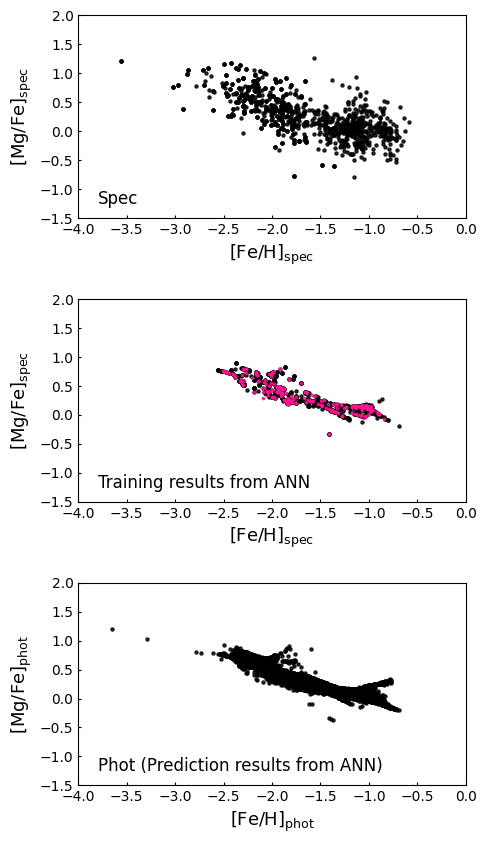

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(5,10), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 5 ; alpha = 0.8

# Spectroscopy
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, 0])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Spec', ha='left', va='bottom', transform=ax0.transAxes, color='k', size=12)

# Training
ax1.scatter(train_fnx['FEH_phot_ann_pytorch'], train_fnx['MGFE_phot_ann_pytorch'], s=s, alpha=alpha, color='black')
ax1.scatter(train_scl['FEH_phot_ann_pytorch'], train_scl['MGFE_phot_ann_pytorch'], s=s, alpha=alpha, color='black')
ax1.scatter(train_umi['FEH_phot_ann_pytorch'], train_umi['MGFE_phot_ann_pytorch'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dra['FEH_phot_ann_pytorch'], train_dra['MGFE_phot_ann_pytorch'], s=s, alpha=alpha, color='black')
ax1.scatter(test_fnx['FEH_phot_ann_pytorch'], test_fnx['MGFE_phot_ann_pytorch'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_scl['FEH_phot_ann_pytorch'], test_scl['MGFE_phot_ann_pytorch'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_umi['FEH_phot_ann_pytorch'], test_umi['MGFE_phot_ann_pytorch'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_dra['FEH_phot_ann_pytorch'], test_dra['MGFE_phot_ann_pytorch'], s=3, alpha=alpha, color='deeppink')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax1.set_xlim([-4, 0])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Training results from ANN', ha='left', va='bottom', transform=ax1.transAxes, color='k', size=12)

# Photometry
ax2.scatter(hsc_fnx_mag['FEH_phot_ann_pytorch'], hsc_fnx_mag['MGFE_phot_ann_pytorch'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_scl_mag['FEH_phot_ann_pytorch'], hsc_scl_mag['MGFE_phot_ann_pytorch'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_umi_mag['FEH_phot_ann_pytorch'], hsc_umi_mag['MGFE_phot_ann_pytorch'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_dra_mag['FEH_phot_ann_pytorch'], hsc_dra_mag['MGFE_phot_ann_pytorch'], s=s, alpha=alpha, color='black')
ax2.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax2.set_xlim([-4, 0])
ax2.set_ylim([-1.5, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.05, 0.05, 'Phot (Prediction results from ANN)', ha='left', va='bottom', transform=ax2.transAxes, color='k', size=12)

plt.savefig('feh_mgfe_phot_spec_scatter_ANN_pytorch.png', bbox_inches='tight')

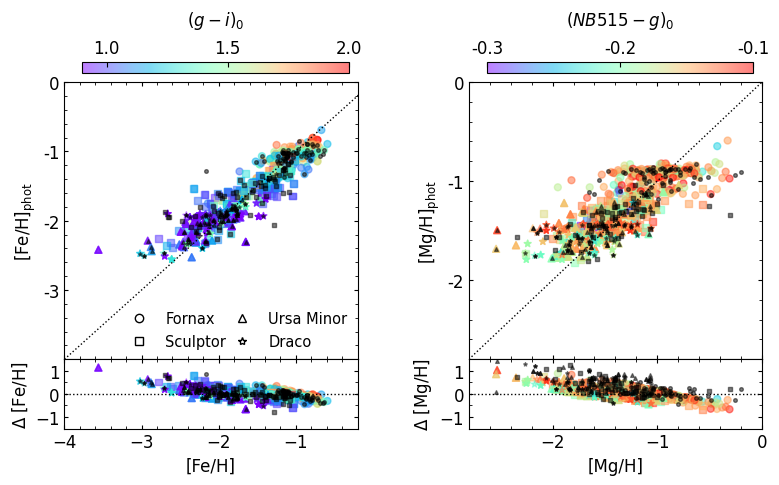

In [13]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 4.5), gridspec_kw={'wspace':0.38, 'hspace':0, 'height_ratios': [1, 0.25]})
s = 25 ; alpha = 0.5
xmin, xmax = -4, -0.2
vmin, vmax = 0.9, 2
color = 'deeppink'
markers = ['o', 's', '^', '*']

# Training
# [Fe/H]
ax0.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax0.scatter(train_fnx['FEH'], train_fnx['FEH_phot_ann_pytorch'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax0.scatter(train_scl['FEH'], train_scl['FEH_phot_ann_pytorch'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax0.scatter(train_umi['FEH'], train_umi['FEH_phot_ann_pytorch'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax0.scatter(train_dra['FEH'], train_dra['FEH_phot_ann_pytorch'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax0.scatter(test_fnx['FEH'], test_fnx['FEH_phot_ann_pytorch'], s=7, alpha=0.5, marker=markers[0], color='black')
ax0.scatter(test_scl['FEH'], test_scl['FEH_phot_ann_pytorch'], s=7, alpha=0.5, marker=markers[1], color='black')
ax0.scatter(test_umi['FEH'], test_umi['FEH_phot_ann_pytorch'], s=7, alpha=0.5, marker=markers[2], color='black')
ax0.scatter(test_dra['FEH'], test_dra['FEH_phot_ann_pytorch'], s=7, alpha=0.5, marker=markers[3], color='black')

custom_legend = [
    Line2D([0], [0], linestyle='None', marker=markers[0], color='k', markerfacecolor='w', markersize=6, label='Fornax'),
    Line2D([0], [0], linestyle='None', marker=markers[1], color='k', markerfacecolor='w', markersize=6, label='Sculptor'),
    Line2D([0], [0], linestyle='None', marker=markers[2], color='k', markerfacecolor='w', markersize=6, label='Ursa Minor'),
    Line2D([0], [0], linestyle='None', marker=markers[3], color='k', markerfacecolor='w', markersize=6, label='Draco'),
]
legend = ax0.legend(handles=custom_legend, fontsize=10.5, framealpha=0, ncol=2, columnspacing=0.1)
legend.set_bbox_to_anchor((0.16, 0.12, 0.3, 0.1), transform=ax0.transAxes)
ax0.set_xlabel('')
ax0.set_ylabel('[Fe/H]$_\mathrm{phot}$', size=12)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([xmin, xmax])
ax0.set_xticklabels('')
ax0.set_yticks([-3, -2, -1, 0])
ax0.set_yticklabels(['-3', '-2', '-1', '0'])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator(5))
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax0.text(0.05, 0.96, f'Training (N={len(train_FEH)}, RMSE={train_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
#ax0.text(0.05, 0.88, f'Test (N={len(test_FEH)}, RMSE={test_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.02, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(g - i)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([1.0, 1.5, 2.0])
cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])
#m_train, b_train = np.polyfit(train_FEH['FEH'], train_FEH['FEH_phot_ann_pytorch'], 1)
#ax0.plot(np.linspace(xmin, xmax, 100), m_train * np.linspace(xmin, xmax, 100) + b_train, color='black', linestyle='-', linewidth=1.5, label='Train Fit')
#print('m_train =', m_train)

ax2.axhline(0, xmin, xmax+2, color='k', linewidth=1, linestyle=':')
ax2.scatter(train_fnx['FEH'], train_fnx['FEH_phot_ann_pytorch']-train_fnx['FEH'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax2.scatter(train_scl['FEH'], train_scl['FEH_phot_ann_pytorch']-train_scl['FEH'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax2.scatter(train_umi['FEH'], train_umi['FEH_phot_ann_pytorch']-train_umi['FEH'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax2.scatter(train_dra['FEH'], train_dra['FEH_phot_ann_pytorch']-train_dra['FEH'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax2.scatter(test_fnx['FEH'], test_fnx['FEH_phot_ann_pytorch']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax2.scatter(test_scl['FEH'], test_scl['FEH_phot_ann_pytorch']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax2.scatter(test_umi['FEH'], test_umi['FEH_phot_ann_pytorch']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax2.scatter(test_dra['FEH'], test_dra['FEH_phot_ann_pytorch']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax2.set_xlabel('[Fe/H]', size=12)
ax2.set_ylabel('$\Delta$ [Fe/H]', size=12)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([-1.5, 1.5])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)


# Test
# [Mg/H]
xmin, xmax = -2.8, 0
vmin, vmax = -0.3, -0.1
ax1.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax1.scatter(train_fnx['MGH'], train_fnx['MGH_phot_ann_pytorch'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax1.scatter(train_scl['MGH'], train_scl['MGH_phot_ann_pytorch'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax1.scatter(train_umi['MGH'], train_umi['MGH_phot_ann_pytorch'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax1.scatter(train_dra['MGH'], train_dra['MGH_phot_ann_pytorch'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax1.scatter(test_fnx['MGH'], test_fnx['MGH_phot_ann_pytorch'], s=7, alpha=0.5, marker=markers[0], color='black')
ax1.scatter(test_scl['MGH'], test_scl['MGH_phot_ann_pytorch'], s=7, alpha=0.5, marker=markers[1], color='black')
ax1.scatter(test_umi['MGH'], test_umi['MGH_phot_ann_pytorch'], s=7, alpha=0.5, marker=markers[2], color='black')
ax1.scatter(test_dra['MGH'], test_dra['MGH_phot_ann_pytorch'], s=7, alpha=0.5, marker=markers[3], color='black')

ax1.set_xlabel('')
ax1.set_ylabel('[Mg/H]$_\mathrm{phot}$', size=12)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([xmin, xmax])
ax1.set_xticklabels('')
ax1.set_yticks([-2, -1, 0])
ax1.set_yticklabels(['-2', '-1', '0'])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax1.text(0.05, 0.96, f'Training (N={len(train_MGH)}, RMSE={train_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
#ax1.text(0.05, 0.88, f'Test (N={len(test_MGH)}, RMSE={test_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.02, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(NB515 - g)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([-0.3, -0.2, -0.1])
cbar.ax.set_xticklabels(['-0.3', '-0.2', '-0.1'])
#m_test, b_test = np.polyfit(test_FEH['MGH'], test_FEH['MGH_phot_ann_pytorch'], 1)
#ax1.plot(np.linspace(xmin, xmax, 100), m_test * np.linspace(xmin, xmax, 100) + b_test, color=color, linestyle='-', linewidth=1.5, label='Test Fit')
#print('m_test =', m_test)

ax3.axhline(0, xmin, xmax+1, color='k', linewidth=1, linestyle=':')
ax3.scatter(train_fnx['MGH'], train_fnx['MGH_phot_ann_pytorch']-train_fnx['MGH'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax3.scatter(train_scl['MGH'], train_scl['MGH_phot_ann_pytorch']-train_scl['MGH'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax3.scatter(train_umi['MGH'], train_umi['MGH_phot_ann_pytorch']-train_umi['MGH'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax3.scatter(train_dra['MGH'], train_dra['MGH_phot_ann_pytorch']-train_dra['MGH'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax3.scatter(test_fnx['MGH'], test_fnx['MGH_phot_ann_pytorch']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax3.scatter(test_scl['MGH'], test_scl['MGH_phot_ann_pytorch']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax3.scatter(test_umi['MGH'], test_umi['MGH_phot_ann_pytorch']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax3.scatter(test_dra['MGH'], test_dra['MGH_phot_ann_pytorch']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax3.set_xlabel('[Mg/H]', size=12)
ax3.set_ylabel('$\Delta$ [Mg/H]', size=12)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([-1.5, 1.5])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

plt.savefig('feh_mgh_training_test_residuals_ANN_pytorch.png', bbox_inches='tight')

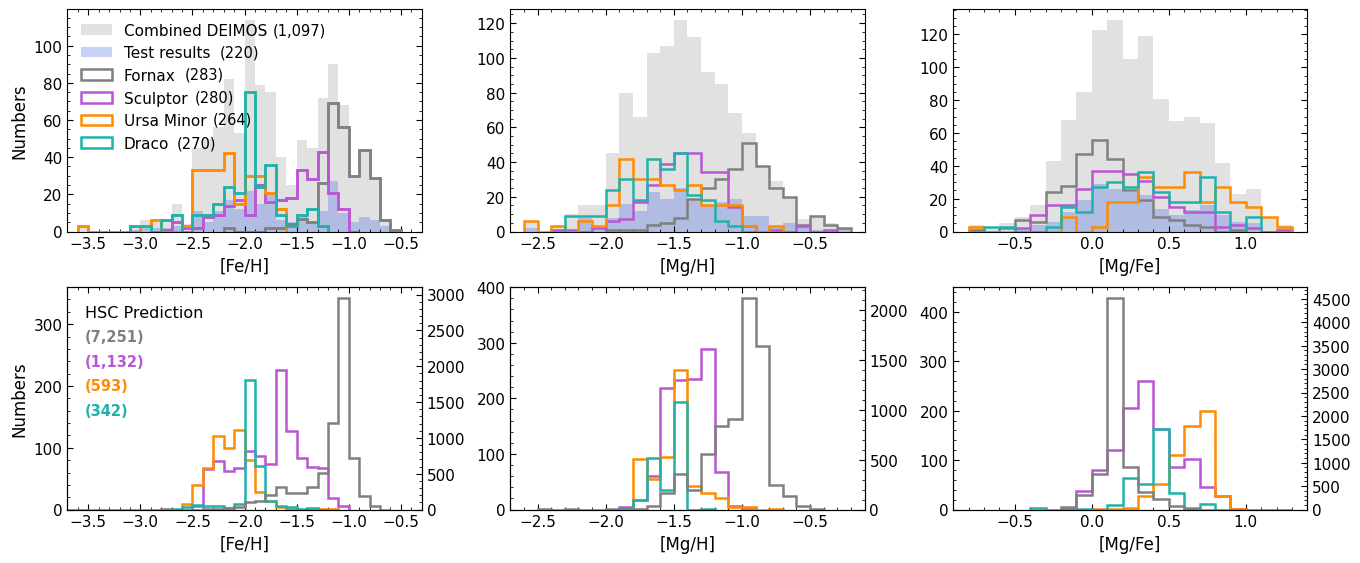

In [14]:
def plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    for data, color in zip(data_list, colors):
        ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                histtype='step', linestyle=linestyle, color=color, linewidth=1.8, alpha=alpha)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    if show_legend:
        for data, label, color in zip(data_list, labels, colors):
            ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                    histtype='step', linestyle=linestyle, color=color, label=label, linewidth=1.8, alpha=alpha)
        ax.legend(loc='upper left', frameon=False, fontsize=11)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)

def plot_with_twinx(ax_twin, ax, twin_data, data_list, twin_label, labels, twin_color, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    ax_twin.hist(twin_data, bins=np.arange(np.floor(np.min(twin_data) / bins_width) * bins_width,
                                     np.ceil(np.max(twin_data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                 histtype='step', linestyle=linestyle, color=twin_color, label=twin_label, linewidth=1.8, alpha=alpha)
    plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width, show_legend, linestyle)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax_twin.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax_twin.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax_twin.yaxis.set_minor_locator(MultipleLocator(100))
    ax_twin.yaxis.set_major_locator(MultipleLocator(500))
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_twin, labels_twin = ax_twin.get_legend_handles_labels()
        ax.legend(handles_twin + handles, labels_twin + labels, loc='upper left', frameon=False, fontsize=10)



# Set up the figure and axes
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 6.5), gridspec_kw={'wspace': 0.25, 'hspace': 0.25})
bins_width = 0.1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']
alpha = 1

# 1st row 
ax0.hist(df_mag['FEH'], bins=np.arange(np.floor(np.min(df_mag['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2, label='Combined DEIMOS')
ax0.hist(test_dataset['FEH'], bins=np.arange(np.floor(np.min(test_dataset['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3, label='Test results')
plot_histogram(ax0, [fnx_mag['FEH'], scl_mag['FEH'], umi_mag['FEH'], dra_mag['FEH']], labels, colors, alpha, '[Fe/H]', 'Numbers')
ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_xlim([-3.7, -0.3])
ax0.text(0.58, 0.94, '({0:,.0f})'.format(len(df_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.43, 0.84, '({0:,.0f})'.format(len(test_dataset['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.33, 0.74, '({0:,.0f})'.format(len(fnx_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.36, 0.64, '({0:,.0f})'.format(len(scl_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.41, 0.54, '({0:,.0f})'.format(len(umi_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.31, 0.43, '({0:,.0f})'.format(len(dra_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)

ax1.hist(df_mag['MGH'], bins=np.arange(np.floor(np.min(df_mag['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax1.hist(test_dataset['MGH'], bins=np.arange(np.floor(np.min(test_dataset['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax1, [fnx_mag['MGH'], scl_mag['MGH'], umi_mag['MGH'], dra_mag['MGH']], labels, colors, alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax1.set_xlim([-2.7, -0.1])

ax2.hist(df_mag['MGFE'], bins=np.arange(np.floor(np.min(df_mag['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax2.hist(test_dataset['MGFE'], bins=np.arange(np.floor(np.min(test_dataset['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax2, [fnx_mag['MGFE'], scl_mag['MGFE'], umi_mag['MGFE'], dra_mag['MGFE']], labels, colors, alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax2.set_xlim([-0.9, 1.4])

# 2nd row
plot_with_twinx(ax3.twinx(), ax3,
                hsc_fnx_mag['FEH_phot_ann_pytorch'], [hsc_scl_mag['FEH_phot_ann_pytorch'], hsc_umi_mag['FEH_phot_ann_pytorch'], hsc_dra_mag['FEH_phot_ann_pytorch']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Fe/H]', 'Numbers', show_legend=False)
ax3.set_xlim([-3.7, -0.3])
ax3.set_ylim([0, 360])
ax3.text(0.05, 0.92, 'HSC Prediction', ha='left', va='top', transform=ax3.transAxes, size=11.5)
ax3.text(0.05, 0.81, '({0:,.0f})'.format(len(hsc_fnx_mag['FEH_phot_ann_pytorch'])), ha='left', va='top', color=colors[0], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.70, '({0:,.0f})'.format(len(hsc_scl_mag['FEH_phot_ann_pytorch'])), ha='left', va='top', color=colors[1], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.59, '({0:,.0f})'.format(len(hsc_umi_mag['FEH_phot_ann_pytorch'])), ha='left', va='top', color=colors[2], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.48, '({0:,.0f})'.format(len(hsc_dra_mag['FEH_phot_ann_pytorch'])), ha='left', va='top', color=colors[3], size=10.5, transform=ax3.transAxes, fontweight='bold')

plot_with_twinx(ax4.twinx(), ax4, 
                hsc_fnx_mag['MGH_phot_ann_pytorch'], [hsc_scl_mag['MGH_phot_ann_pytorch'], hsc_umi_mag['MGH_phot_ann_pytorch'], hsc_dra_mag['MGH_phot_ann_pytorch']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax4.set_xlim([-2.7, -0.1])
ax4.set_ylim([0, 400])

plot_with_twinx(ax5.twinx(), ax5, 
                hsc_fnx_mag['MGFE_phot_ann_pytorch'], [hsc_scl_mag['MGFE_phot_ann_pytorch'], hsc_umi_mag['MGFE_phot_ann_pytorch'], hsc_dra_mag['MGFE_phot_ann_pytorch']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax5.set_xlim([-0.9, 1.4])
ax5.set_ylim([0, 450])

for ax in [ax1, ax2, ax4, ax5]:
    ax.set_ylabel('')

plt.savefig('feh_mgh_mgfe_distribution_ANN_pytorch.png', bbox_inches='tight')

In [15]:
data = {
    'FEH': [
        f"{np.mean(fnx_mag['FEH']):.2f} ± {np.std(fnx_mag['FEH']):.2f}",
        f"{np.mean(scl_mag['FEH']):.2f} ± {np.std(scl_mag['FEH']):.2f}",
        f"{np.mean(umi_mag['FEH']):.2f} ± {np.std(umi_mag['FEH']):.2f}",
        f"{np.mean(dra_mag['FEH']):.2f} ± {np.std(dra_mag['FEH']):.2f}",
        f"{np.mean(hsc_fnx_mag['FEH_phot_ann_pytorch']):.2f} ± {np.std(hsc_fnx_mag['FEH_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_scl_mag['FEH_phot_ann_pytorch']):.2f} ± {np.std(hsc_scl_mag['FEH_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_umi_mag['FEH_phot_ann_pytorch']):.2f} ± {np.std(hsc_umi_mag['FEH_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_dra_mag['FEH_phot_ann_pytorch']):.2f} ± {np.std(hsc_dra_mag['FEH_phot_ann_pytorch']):.2f}"
    ],
    'MGH': [
        f"{np.mean(fnx_mag['MGH']):.2f} ± {np.std(fnx_mag['MGH']):.2f}",
        f"{np.mean(scl_mag['MGH']):.2f} ± {np.std(scl_mag['MGH']):.2f}",
        f"{np.mean(umi_mag['MGH']):.2f} ± {np.std(umi_mag['MGH']):.2f}",
        f"{np.mean(dra_mag['MGH']):.2f} ± {np.std(dra_mag['MGH']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGH_phot_ann_pytorch']):.2f} ± {np.std(hsc_fnx_mag['MGH_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_scl_mag['MGH_phot_ann_pytorch']):.2f} ± {np.std(hsc_scl_mag['MGH_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_umi_mag['MGH_phot_ann_pytorch']):.2f} ± {np.std(hsc_umi_mag['MGH_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_dra_mag['MGH_phot_ann_pytorch']):.2f} ± {np.std(hsc_dra_mag['MGH_phot_ann_pytorch']):.2f}"
    ],
    'MGFE': [
        f"{np.mean(fnx_mag['MGFE']):.2f} ± {np.std(fnx_mag['MGFE']):.2f}",
        f"{np.mean(scl_mag['MGFE']):.2f} ± {np.std(scl_mag['MGFE']):.2f}",
        f"{np.mean(umi_mag['MGFE']):.2f} ± {np.std(umi_mag['MGFE']):.2f}",
        f"{np.mean(dra_mag['MGFE']):.2f} ± {np.std(dra_mag['MGFE']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGFE_phot_ann_pytorch']):.2f} ± {np.std(hsc_fnx_mag['MGFE_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_scl_mag['MGFE_phot_ann_pytorch']):.2f} ± {np.std(hsc_scl_mag['MGFE_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_umi_mag['MGFE_phot_ann_pytorch']):.2f} ± {np.std(hsc_umi_mag['MGFE_phot_ann_pytorch']):.2f}",
        f"{np.mean(hsc_dra_mag['MGFE_phot_ann_pytorch']):.2f} ± {np.std(hsc_dra_mag['MGFE_phot_ann_pytorch']):.2f}"
    ]
}

index = [
    'fnx_mag', 'scl_mag', 'umi_mag', 'dra_mag',
    'hsc_fnx_mag', 'hsc_scl_mag', 'hsc_umi_mag', 'hsc_dra_mag'
]

df = pd.DataFrame(data, index=index)

df.to_csv('feh_mgh_mgfe_mean_std_ANN_pytorch.csv', index=False)

# ANN using Scikit-learn

Iteration 1, loss = 0.96554110
Validation score: -1.930730
Iteration 2, loss = 0.45239626
Validation score: -3.205725
Iteration 3, loss = 0.25279544
Validation score: -1.142763
Iteration 4, loss = 0.15412551
Validation score: 0.128850
Iteration 5, loss = 0.10244737
Validation score: 0.097528
Iteration 6, loss = 0.07159718
Validation score: 0.165028
Iteration 7, loss = 0.07072626
Validation score: 0.353938
Iteration 8, loss = 0.06250021
Validation score: 0.382271
Iteration 9, loss = 0.05506720
Validation score: 0.390369
Iteration 10, loss = 0.05287836
Validation score: 0.421780
Iteration 11, loss = 0.05277153
Validation score: 0.440653
Iteration 12, loss = 0.04908153
Validation score: 0.453218
Iteration 13, loss = 0.04899808
Validation score: 0.470553
Iteration 14, loss = 0.04828458
Validation score: 0.476914
Iteration 15, loss = 0.04732856
Validation score: 0.493608
Iteration 16, loss = 0.04774068
Validation score: 0.492260
Iteration 17, loss = 0.04522026
Validation score: 0.504269
Ite

/afs/crc.nd.edu/user/j/jhong5/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


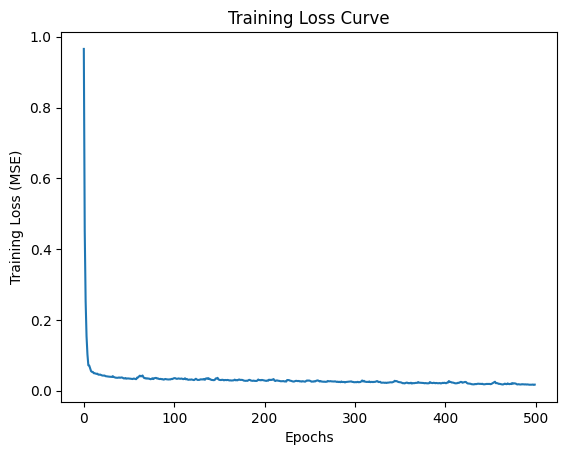

Train R² FEH: 0.8513257108892365
Train R² MGH: 0.6146970601968422
Train R² FEH: 0.8936105375816472
Train R² MGH: 0.6861262063708807
CPU times: user 17min 30s, sys: 5.99 s, total: 17min 36s
Wall time: 17min 35s


In [16]:
%%time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# Split the data
train_dataset, test_dataset = train_test_split(df_mag, test_size=0.2, random_state=42)

# Input features
features = ['Mg0', 'Mi0', 'Mn0', 'galaxy_id']
targets  = ['FEH', 'MGH']

X_train = train_dataset[features]
y_train = train_dataset[targets]

# Make a model using MLPRegressor of Scikit-learn
# 5 hidden layers with 1024 units, activating relu
model_ann = MLPRegressor(hidden_layer_sizes=(1024, 1024, 1024, 1024, 1024),
                         activation='relu',
                         solver='adam',             # RMSprop과 유사한 최적화 알고리즘으로 adam 사용
                         learning_rate_init=0.001,
                         max_iter=500,              # 최대 에포크 수
                         early_stopping=True,       # 내부 validation split 사용
                         validation_fraction=0.2,   # train 데이터 중 20%를 validation으로 사용
                         n_iter_no_change=500,      # patience에 해당 (개선 없을 시 조기 종료)
                         random_state=42,
                         verbose=True)

# Make a model
model_ann.fit(X_train, y_train)

# 학습 과정 시각화 (loss_curve_는 훈련 손실 MSE 기록)
plt.figure()
plt.plot(model_ann.loss_curve_)
plt.xlabel('Epochs')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Curve')
plt.show()

# Get predictions
# Save the predictions to the test samples
X_test = test_dataset[features]
test_predictions = model_ann.predict(X_test)
test_dataset['FEH_phot_ann_sklearn'] = test_predictions[:, 0]
test_dataset['MGH_phot_ann_sklearn'] = test_predictions[:, 1]
test_dataset['MGFE_phot_ann_sklearn'] = test_dataset['MGH_phot_ann_sklearn'] - test_dataset['FEH_phot_ann_sklearn']
test_r2_feh = r2_score(test_dataset['FEH'], test_dataset['FEH_phot_ann_sklearn'])
test_r2_mgh = r2_score(test_dataset['MGH'], test_dataset['MGH_phot_ann_sklearn'])
print("Train R² FEH:", test_r2_feh) #0.8513257108892365
print("Train R² MGH:", test_r2_mgh) #0.6146970601968422

# Save the predictions to the training samples
train_predictions = model_ann.predict(X_train)
train_dataset['FEH_phot_ann_sklearn'] = train_predictions[:, 0]
train_dataset['MGH_phot_ann_sklearn'] = train_predictions[:, 1]
train_dataset['MGFE_phot_ann_sklearn'] = train_dataset['MGH_phot_ann_sklearn'] - train_dataset['FEH_phot_ann_sklearn']
train_r2_feh = r2_score(train_dataset['FEH'], train_dataset['FEH_phot_ann_sklearn'])
train_r2_mgh = r2_score(train_dataset['MGH'], train_dataset['MGH_phot_ann_sklearn'])
print("Train R² FEH:", train_r2_feh) #0.8936105375816472
print("Train R² MGH:", train_r2_mgh) #0.6861262063708807

# Save the predictions to the HSC samples
X_hsc = hsc_df_mag[features]
hsc_predictions = model_ann.predict(X_hsc)
hsc_df_mag['FEH_phot_ann_sklearn'] = hsc_predictions[:, 0]
hsc_df_mag['MGH_phot_ann_sklearn'] = hsc_predictions[:, 1]
hsc_df_mag['MGFE_phot_ann_sklearn'] = hsc_df_mag['MGH_phot_ann_sklearn'] - hsc_df_mag['FEH_phot_ann_sklearn']

#Wall time: 17min 47s

In [17]:
train_fnx = train_dataset[train_dataset['galaxy_id'] == 0]
train_scl = train_dataset[train_dataset['galaxy_id'] == 1]
train_umi = train_dataset[train_dataset['galaxy_id'] == 2]
train_dra = train_dataset[train_dataset['galaxy_id'] == 3]

test_fnx = test_dataset[test_dataset['galaxy_id'] == 0]
test_scl = test_dataset[test_dataset['galaxy_id'] == 1]
test_umi = test_dataset[test_dataset['galaxy_id'] == 2]
test_dra = test_dataset[test_dataset['galaxy_id'] == 3]

hsc_fnx_mag = hsc_df_mag[hsc_df_mag['name'] == 'for']
hsc_scl_mag = hsc_df_mag[hsc_df_mag['name'] == 'scl']
hsc_umi_mag = hsc_df_mag[hsc_df_mag['name'] == 'umi']
hsc_dra_mag = hsc_df_mag[hsc_df_mag['name'] == 'dra']

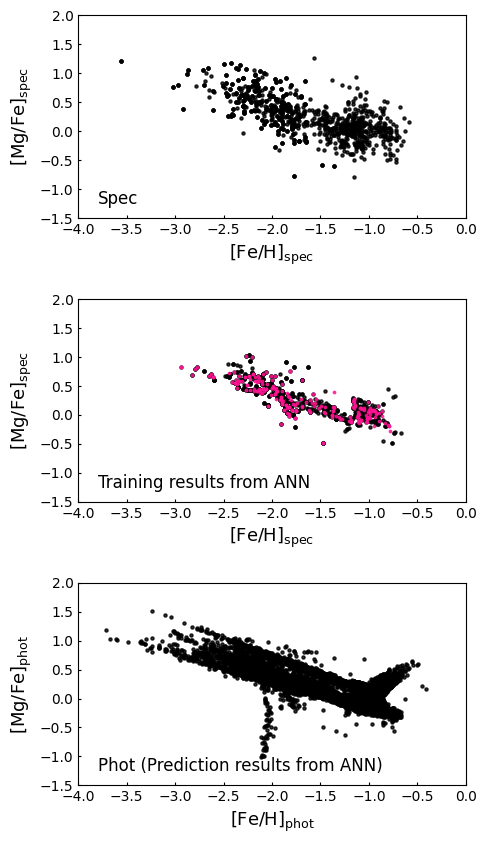

In [18]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(5,10), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 5 ; alpha = 0.8

# Spectroscopy
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, 0])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Spec', ha='left', va='bottom', transform=ax0.transAxes, color='k', size=12)

# Training
ax1.scatter(train_fnx['FEH_phot_ann_sklearn'], train_fnx['MGFE_phot_ann_sklearn'], s=s, alpha=alpha, color='black')
ax1.scatter(train_scl['FEH_phot_ann_sklearn'], train_scl['MGFE_phot_ann_sklearn'], s=s, alpha=alpha, color='black')
ax1.scatter(train_umi['FEH_phot_ann_sklearn'], train_umi['MGFE_phot_ann_sklearn'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dra['FEH_phot_ann_sklearn'], train_dra['MGFE_phot_ann_sklearn'], s=s, alpha=alpha, color='black')
ax1.scatter(test_fnx['FEH_phot_ann_sklearn'], test_fnx['MGFE_phot_ann_sklearn'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_scl['FEH_phot_ann_sklearn'], test_scl['MGFE_phot_ann_sklearn'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_umi['FEH_phot_ann_sklearn'], test_umi['MGFE_phot_ann_sklearn'], s=3, alpha=alpha, color='deeppink')
ax1.scatter(test_dra['FEH_phot_ann_sklearn'], test_dra['MGFE_phot_ann_sklearn'], s=3, alpha=alpha, color='deeppink')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax1.set_xlim([-4, 0])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Training results from ANN', ha='left', va='bottom', transform=ax1.transAxes, color='k', size=12)

# Photometry
ax2.scatter(hsc_fnx_mag['FEH_phot_ann_sklearn'], hsc_fnx_mag['MGFE_phot_ann_sklearn'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_scl_mag['FEH_phot_ann_sklearn'], hsc_scl_mag['MGFE_phot_ann_sklearn'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_umi_mag['FEH_phot_ann_sklearn'], hsc_umi_mag['MGFE_phot_ann_sklearn'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_dra_mag['FEH_phot_ann_sklearn'], hsc_dra_mag['MGFE_phot_ann_sklearn'], s=s, alpha=alpha, color='black')
ax2.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax2.set_xlim([-4, 0])
ax2.set_ylim([-1.5, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.05, 0.05, 'Phot (Prediction results from ANN)', ha='left', va='bottom', transform=ax2.transAxes, color='k', size=12)

plt.savefig('feh_mgfe_phot_spec_scatter_ANN_sklearn.png', bbox_inches='tight')

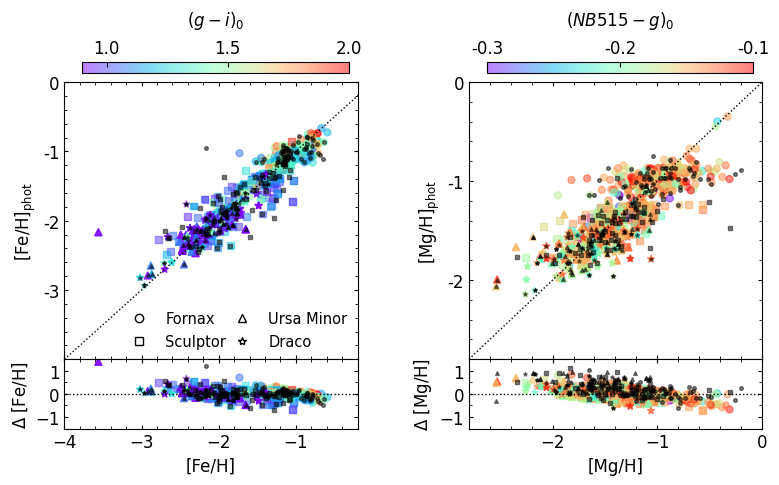

In [19]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 4.5), gridspec_kw={'wspace':0.38, 'hspace':0, 'height_ratios': [1, 0.25]})
s = 25 ; alpha = 0.5
xmin, xmax = -4, -0.2
vmin, vmax = 0.9, 2
color = 'deeppink'
markers = ['o', 's', '^', '*']

# Training
# [Fe/H]
ax0.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax0.scatter(train_fnx['FEH'], train_fnx['FEH_phot_ann_sklearn'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax0.scatter(train_scl['FEH'], train_scl['FEH_phot_ann_sklearn'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax0.scatter(train_umi['FEH'], train_umi['FEH_phot_ann_sklearn'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax0.scatter(train_dra['FEH'], train_dra['FEH_phot_ann_sklearn'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax0.scatter(test_fnx['FEH'], test_fnx['FEH_phot_ann_sklearn'], s=7, alpha=0.5, marker=markers[0], color='black')
ax0.scatter(test_scl['FEH'], test_scl['FEH_phot_ann_sklearn'], s=7, alpha=0.5, marker=markers[1], color='black')
ax0.scatter(test_umi['FEH'], test_umi['FEH_phot_ann_sklearn'], s=7, alpha=0.5, marker=markers[2], color='black')
ax0.scatter(test_dra['FEH'], test_dra['FEH_phot_ann_sklearn'], s=7, alpha=0.5, marker=markers[3], color='black')

custom_legend = [
    Line2D([0], [0], linestyle='None', marker=markers[0], color='k', markerfacecolor='w', markersize=6, label='Fornax'),
    Line2D([0], [0], linestyle='None', marker=markers[1], color='k', markerfacecolor='w', markersize=6, label='Sculptor'),
    Line2D([0], [0], linestyle='None', marker=markers[2], color='k', markerfacecolor='w', markersize=6, label='Ursa Minor'),
    Line2D([0], [0], linestyle='None', marker=markers[3], color='k', markerfacecolor='w', markersize=6, label='Draco'),
]
legend = ax0.legend(handles=custom_legend, fontsize=10.5, framealpha=0, ncol=2, columnspacing=0.1)
legend.set_bbox_to_anchor((0.16, 0.12, 0.3, 0.1), transform=ax0.transAxes)
ax0.set_xlabel('')
ax0.set_ylabel('[Fe/H]$_\mathrm{phot}$', size=12)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([xmin, xmax])
ax0.set_xticklabels('')
ax0.set_yticks([-3, -2, -1, 0])
ax0.set_yticklabels(['-3', '-2', '-1', '0'])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator(5))
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax0.text(0.05, 0.96, f'Training (N={len(train_FEH)}, RMSE={train_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
#ax0.text(0.05, 0.88, f'Test (N={len(test_FEH)}, RMSE={test_FEH_rmse_avg:.3f})', ha='left', va='top', transform=ax0.transAxes, size=11)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.02, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(g - i)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([1.0, 1.5, 2.0])
cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])
#m_train, b_train = np.polyfit(train_FEH['FEH'], train_FEH['FEH_phot_ann_sklearn'], 1)
#ax0.plot(np.linspace(xmin, xmax, 100), m_train * np.linspace(xmin, xmax, 100) + b_train, color='black', linestyle='-', linewidth=1.5, label='Train Fit')
#print('m_train =', m_train)

ax2.axhline(0, xmin, xmax+2, color='k', linewidth=1, linestyle=':')
ax2.scatter(train_fnx['FEH'], train_fnx['FEH_phot_ann_sklearn']-train_fnx['FEH'], s=s, alpha=alpha, c=train_fnx['Mg0']-train_fnx['Mi0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax2.scatter(train_scl['FEH'], train_scl['FEH_phot_ann_sklearn']-train_scl['FEH'], s=s, alpha=alpha, c=train_scl['Mg0']-train_scl['Mi0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax2.scatter(train_umi['FEH'], train_umi['FEH_phot_ann_sklearn']-train_umi['FEH'], s=s, alpha=alpha, c=train_umi['Mg0']-train_umi['Mi0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax2.scatter(train_dra['FEH'], train_dra['FEH_phot_ann_sklearn']-train_dra['FEH'], s=s, alpha=alpha, c=train_dra['Mg0']-train_dra['Mi0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax2.scatter(test_fnx['FEH'], test_fnx['FEH_phot_ann_sklearn']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax2.scatter(test_scl['FEH'], test_scl['FEH_phot_ann_sklearn']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax2.scatter(test_umi['FEH'], test_umi['FEH_phot_ann_sklearn']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax2.scatter(test_dra['FEH'], test_dra['FEH_phot_ann_sklearn']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax2.set_xlabel('[Fe/H]', size=12)
ax2.set_ylabel('$\Delta$ [Fe/H]', size=12)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([-1.5, 1.5])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)


# Test
# [Mg/H]
xmin, xmax = -2.8, 0
vmin, vmax = -0.3, -0.1
ax1.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax1.scatter(train_fnx['MGH'], train_fnx['MGH_phot_ann_sklearn'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax1.scatter(train_scl['MGH'], train_scl['MGH_phot_ann_sklearn'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax1.scatter(train_umi['MGH'], train_umi['MGH_phot_ann_sklearn'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax1.scatter(train_dra['MGH'], train_dra['MGH_phot_ann_sklearn'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax1.scatter(test_fnx['MGH'], test_fnx['MGH_phot_ann_sklearn'], s=7, alpha=0.5, marker=markers[0], color='black')
ax1.scatter(test_scl['MGH'], test_scl['MGH_phot_ann_sklearn'], s=7, alpha=0.5, marker=markers[1], color='black')
ax1.scatter(test_umi['MGH'], test_umi['MGH_phot_ann_sklearn'], s=7, alpha=0.5, marker=markers[2], color='black')
ax1.scatter(test_dra['MGH'], test_dra['MGH_phot_ann_sklearn'], s=7, alpha=0.5, marker=markers[3], color='black')

ax1.set_xlabel('')
ax1.set_ylabel('[Mg/H]$_\mathrm{phot}$', size=12)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([xmin, xmax])
ax1.set_xticklabels('')
ax1.set_yticks([-2, -1, 0])
ax1.set_yticklabels(['-2', '-1', '0'])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax1.text(0.05, 0.96, f'Training (N={len(train_MGH)}, RMSE={train_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
#ax1.text(0.05, 0.88, f'Test (N={len(test_MGH)}, RMSE={test_MGH_rmse_avg:.3f})', ha='left', va='top', transform=ax1.transAxes, size=11)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.02, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12, direction='in')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$(NB515 - g)_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([-0.3, -0.2, -0.1])
cbar.ax.set_xticklabels(['-0.3', '-0.2', '-0.1'])
#m_test, b_test = np.polyfit(test_FEH['MGH'], test_FEH['MGH_phot_ann_sklearn'], 1)
#ax1.plot(np.linspace(xmin, xmax, 100), m_test * np.linspace(xmin, xmax, 100) + b_test, color=color, linestyle='-', linewidth=1.5, label='Test Fit')
#print('m_test =', m_test)

ax3.axhline(0, xmin, xmax+1, color='k', linewidth=1, linestyle=':')
ax3.scatter(train_fnx['MGH'], train_fnx['MGH_phot_ann_sklearn']-train_fnx['MGH'], s=s, alpha=alpha, c=train_fnx['Mn0']-train_fnx['Mg0'], cmap='rainbow', marker=markers[0], vmin=vmin, vmax=vmax)
ax3.scatter(train_scl['MGH'], train_scl['MGH_phot_ann_sklearn']-train_scl['MGH'], s=s, alpha=alpha, c=train_scl['Mn0']-train_scl['Mg0'], cmap='rainbow', marker=markers[1], vmin=vmin, vmax=vmax)
ax3.scatter(train_umi['MGH'], train_umi['MGH_phot_ann_sklearn']-train_umi['MGH'], s=s, alpha=alpha, c=train_umi['Mn0']-train_umi['Mg0'], cmap='rainbow', marker=markers[2], vmin=vmin, vmax=vmax)
ax3.scatter(train_dra['MGH'], train_dra['MGH_phot_ann_sklearn']-train_dra['MGH'], s=s, alpha=alpha, c=train_dra['Mn0']-train_dra['Mg0'], cmap='rainbow', marker=markers[3], vmin=vmin, vmax=vmax)

ax3.scatter(test_fnx['MGH'], test_fnx['MGH_phot_ann_sklearn']-test_fnx['FEH'], s=7, alpha=0.5, marker=markers[0], color='black')
ax3.scatter(test_scl['MGH'], test_scl['MGH_phot_ann_sklearn']-test_scl['FEH'], s=7, alpha=0.5, marker=markers[1], color='black')
ax3.scatter(test_umi['MGH'], test_umi['MGH_phot_ann_sklearn']-test_umi['FEH'], s=7, alpha=0.5, marker=markers[2], color='black')
ax3.scatter(test_dra['MGH'], test_dra['MGH_phot_ann_sklearn']-test_dra['FEH'], s=7, alpha=0.5, marker=markers[3], color='black')

ax3.set_xlabel('[Mg/H]', size=12)
ax3.set_ylabel('$\Delta$ [Mg/H]', size=12)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([-1.5, 1.5])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

plt.savefig('feh_mgh_training_test_residuals_ANN_sklearn.png', bbox_inches='tight')

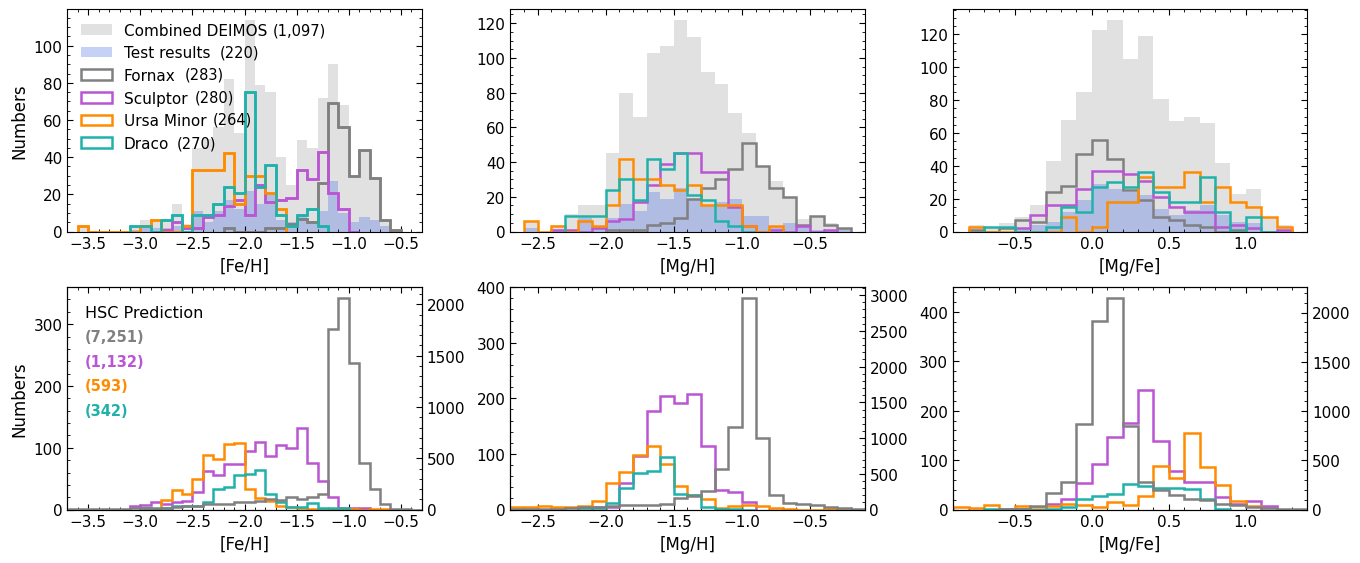

In [20]:
def plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    for data, color in zip(data_list, colors):
        ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                histtype='step', linestyle=linestyle, color=color, linewidth=1.8, alpha=alpha)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    if show_legend:
        for data, label, color in zip(data_list, labels, colors):
            ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                    histtype='step', linestyle=linestyle, color=color, label=label, linewidth=1.8, alpha=alpha)
        ax.legend(loc='upper left', frameon=False, fontsize=11)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)

def plot_with_twinx(ax_twin, ax, twin_data, data_list, twin_label, labels, twin_color, colors, alpha, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    ax_twin.hist(twin_data, bins=np.arange(np.floor(np.min(twin_data) / bins_width) * bins_width,
                                     np.ceil(np.max(twin_data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                 histtype='step', linestyle=linestyle, color=twin_color, label=twin_label, linewidth=1.8, alpha=alpha)
    plot_histogram(ax, data_list, labels, colors, alpha, xlabel, ylabel, bins_width, show_legend, linestyle)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax_twin.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax_twin.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax_twin.yaxis.set_minor_locator(MultipleLocator(100))
    ax_twin.yaxis.set_major_locator(MultipleLocator(500))
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_twin, labels_twin = ax_twin.get_legend_handles_labels()
        ax.legend(handles_twin + handles, labels_twin + labels, loc='upper left', frameon=False, fontsize=10)



# Set up the figure and axes
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 6.5), gridspec_kw={'wspace': 0.25, 'hspace': 0.25})
bins_width = 0.1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']
alpha = 1

# 1st row 
ax0.hist(df_mag['FEH'], bins=np.arange(np.floor(np.min(df_mag['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2, label='Combined DEIMOS')
ax0.hist(test_dataset['FEH'], bins=np.arange(np.floor(np.min(test_dataset['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3, label='Test results')
plot_histogram(ax0, [fnx_mag['FEH'], scl_mag['FEH'], umi_mag['FEH'], dra_mag['FEH']], labels, colors, alpha, '[Fe/H]', 'Numbers')
ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_xlim([-3.7, -0.3])
ax0.text(0.58, 0.94, '({0:,.0f})'.format(len(df_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.43, 0.84, '({0:,.0f})'.format(len(test_dataset['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.33, 0.74, '({0:,.0f})'.format(len(fnx_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.36, 0.64, '({0:,.0f})'.format(len(scl_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.41, 0.54, '({0:,.0f})'.format(len(umi_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)
ax0.text(0.31, 0.43, '({0:,.0f})'.format(len(dra_mag['FEH'])), ha='left', va='top', color='black', size=10.5, transform=ax0.transAxes)

ax1.hist(df_mag['MGH'], bins=np.arange(np.floor(np.min(df_mag['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax1.hist(test_dataset['MGH'], bins=np.arange(np.floor(np.min(test_dataset['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax1, [fnx_mag['MGH'], scl_mag['MGH'], umi_mag['MGH'], dra_mag['MGH']], labels, colors, alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax1.set_xlim([-2.7, -0.1])

ax2.hist(df_mag['MGFE'], bins=np.arange(np.floor(np.min(df_mag['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax2.hist(test_dataset['MGFE'], bins=np.arange(np.floor(np.min(test_dataset['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(test_dataset['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax2, [fnx_mag['MGFE'], scl_mag['MGFE'], umi_mag['MGFE'], dra_mag['MGFE']], labels, colors, alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax2.set_xlim([-0.9, 1.4])

# 2nd row
plot_with_twinx(ax3.twinx(), ax3,
                hsc_fnx_mag['FEH_phot_ann_sklearn'], [hsc_scl_mag['FEH_phot_ann_sklearn'], hsc_umi_mag['FEH_phot_ann_sklearn'], hsc_dra_mag['FEH_phot_ann_sklearn']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Fe/H]', 'Numbers', show_legend=False)
ax3.set_xlim([-3.7, -0.3])
ax3.set_ylim([0, 360])
ax3.text(0.05, 0.92, 'HSC Prediction', ha='left', va='top', transform=ax3.transAxes, size=11.5)
ax3.text(0.05, 0.81, '({0:,.0f})'.format(len(hsc_fnx_mag['FEH_phot_ann_sklearn'])), ha='left', va='top', color=colors[0], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.70, '({0:,.0f})'.format(len(hsc_scl_mag['FEH_phot_ann_sklearn'])), ha='left', va='top', color=colors[1], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.59, '({0:,.0f})'.format(len(hsc_umi_mag['FEH_phot_ann_sklearn'])), ha='left', va='top', color=colors[2], size=10.5, transform=ax3.transAxes, fontweight='bold')
ax3.text(0.05, 0.48, '({0:,.0f})'.format(len(hsc_dra_mag['FEH_phot_ann_sklearn'])), ha='left', va='top', color=colors[3], size=10.5, transform=ax3.transAxes, fontweight='bold')

plot_with_twinx(ax4.twinx(), ax4, 
                hsc_fnx_mag['MGH_phot_ann_sklearn'], [hsc_scl_mag['MGH_phot_ann_sklearn'], hsc_umi_mag['MGH_phot_ann_sklearn'], hsc_dra_mag['MGH_phot_ann_sklearn']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/H]', 'Numbers', show_legend=False)
ax4.set_xlim([-2.7, -0.1])
ax4.set_ylim([0, 400])

plot_with_twinx(ax5.twinx(), ax5, 
                hsc_fnx_mag['MGFE_phot_ann_sklearn'], [hsc_scl_mag['MGFE_phot_ann_sklearn'], hsc_umi_mag['MGFE_phot_ann_sklearn'], hsc_dra_mag['MGFE_phot_ann_sklearn']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], alpha, '[Mg/Fe]', 'Numbers', show_legend=False)
ax5.set_xlim([-0.9, 1.4])
ax5.set_ylim([0, 450])

for ax in [ax1, ax2, ax4, ax5]:
    ax.set_ylabel('')

plt.savefig('feh_mgh_mgfe_distribution_ANN_sklearn.png', bbox_inches='tight')

In [21]:
data = {
    'FEH': [
        f"{np.mean(fnx_mag['FEH']):.2f} ± {np.std(fnx_mag['FEH']):.2f}",
        f"{np.mean(scl_mag['FEH']):.2f} ± {np.std(scl_mag['FEH']):.2f}",
        f"{np.mean(umi_mag['FEH']):.2f} ± {np.std(umi_mag['FEH']):.2f}",
        f"{np.mean(dra_mag['FEH']):.2f} ± {np.std(dra_mag['FEH']):.2f}",
        f"{np.mean(hsc_fnx_mag['FEH_phot_ann_sklearn']):.2f} ± {np.std(hsc_fnx_mag['FEH_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_scl_mag['FEH_phot_ann_sklearn']):.2f} ± {np.std(hsc_scl_mag['FEH_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_umi_mag['FEH_phot_ann_sklearn']):.2f} ± {np.std(hsc_umi_mag['FEH_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_dra_mag['FEH_phot_ann_sklearn']):.2f} ± {np.std(hsc_dra_mag['FEH_phot_ann_sklearn']):.2f}"
    ],
    'MGH': [
        f"{np.mean(fnx_mag['MGH']):.2f} ± {np.std(fnx_mag['MGH']):.2f}",
        f"{np.mean(scl_mag['MGH']):.2f} ± {np.std(scl_mag['MGH']):.2f}",
        f"{np.mean(umi_mag['MGH']):.2f} ± {np.std(umi_mag['MGH']):.2f}",
        f"{np.mean(dra_mag['MGH']):.2f} ± {np.std(dra_mag['MGH']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGH_phot_ann_sklearn']):.2f} ± {np.std(hsc_fnx_mag['MGH_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_scl_mag['MGH_phot_ann_sklearn']):.2f} ± {np.std(hsc_scl_mag['MGH_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_umi_mag['MGH_phot_ann_sklearn']):.2f} ± {np.std(hsc_umi_mag['MGH_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_dra_mag['MGH_phot_ann_sklearn']):.2f} ± {np.std(hsc_dra_mag['MGH_phot_ann_sklearn']):.2f}"
    ],
    'MGFE': [
        f"{np.mean(fnx_mag['MGFE']):.2f} ± {np.std(fnx_mag['MGFE']):.2f}",
        f"{np.mean(scl_mag['MGFE']):.2f} ± {np.std(scl_mag['MGFE']):.2f}",
        f"{np.mean(umi_mag['MGFE']):.2f} ± {np.std(umi_mag['MGFE']):.2f}",
        f"{np.mean(dra_mag['MGFE']):.2f} ± {np.std(dra_mag['MGFE']):.2f}",
        f"{np.mean(hsc_fnx_mag['MGFE_phot_ann_sklearn']):.2f} ± {np.std(hsc_fnx_mag['MGFE_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_scl_mag['MGFE_phot_ann_sklearn']):.2f} ± {np.std(hsc_scl_mag['MGFE_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_umi_mag['MGFE_phot_ann_sklearn']):.2f} ± {np.std(hsc_umi_mag['MGFE_phot_ann_sklearn']):.2f}",
        f"{np.mean(hsc_dra_mag['MGFE_phot_ann_sklearn']):.2f} ± {np.std(hsc_dra_mag['MGFE_phot_ann_sklearn']):.2f}"
    ]
}

index = [
    'fnx_mag', 'scl_mag', 'umi_mag', 'dra_mag',
    'hsc_fnx_mag', 'hsc_scl_mag', 'hsc_umi_mag', 'hsc_dra_mag'
]

df = pd.DataFrame(data, index=index)

df.to_csv('feh_mgh_mgfe_mean_std_ANN_sklearn.csv', index=False)

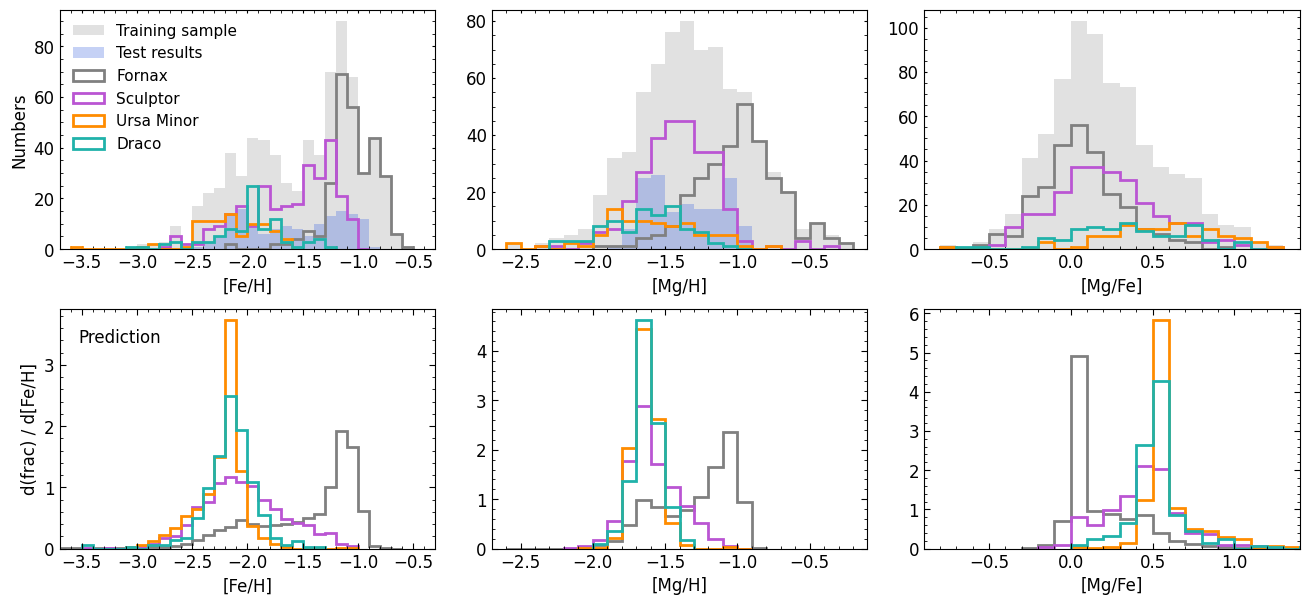

In [40]:
bins_width = 0.1
alpha = 1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 7), gridspec_kw={'wspace': 0.15, 'hspace': 0.25})

data_dict_feh = {
    'Training sample': (df_mag['FEH'], 'dimgray', 0.2),
    'Test results': (Y_pred_FEH, 'royalblue', 0.3),
    'Fornax': (fnx_mag['FEH'], colors[0], alpha),
    'Sculptor': (scl_mag['FEH'], colors[1], alpha),
    'Ursa Minor': (umi_mag['FEH'], colors[2], alpha),
    'Draco': (dra_mag['FEH'], colors[3], alpha)
}

data_dict_mgh = {
    'Training sample': (df_mag['MGH'], 'dimgray', 0.2),
    'Test results': (Y_pred_MGH, 'royalblue', 0.3),
    'Fornax': (fnx_mag['MGH'], colors[0], alpha),
    'Sculptor': (scl_mag['MGH'], colors[1], alpha),
    'Ursa Minor': (umi_mag['MGH'], colors[2], alpha),
    'Draco': (dra_mag['MGH'], colors[3], alpha)
}

data_dict_mgfe = {
    'Training sample': (df_mag['MGFE'], 'dimgray', 0.2),
    'Fornax': (fnx_mag['MGFE'], colors[0], alpha),
    'Sculptor': (scl_mag['MGFE'], colors[1], alpha),
    'Ursa Minor': (umi_mag['MGFE'], colors[2], alpha),
    'Draco': (dra_mag['MGFE'], colors[3], alpha)
}

for data_dict, ax, xlabel in zip(
        [data_dict_feh, data_dict_mgh, data_dict_mgfe],  
        [ax0, ax1, ax2],  
        ['[Fe/H]', '[Mg/H]', '[Mg/Fe]']
):
    for label, (data, color, alpha_value) in data_dict.items():
        bins = np.arange(np.floor(np.min(data) / bins_width) * bins_width, 
                         np.ceil(np.max(data) / bins_width) * bins_width + bins_width, 
                         bins_width)
        ax.hist(data, bins=bins, histtype='step' if label not in ['Training sample', 'Test results'] else 'stepfilled', color=color, alpha=alpha_value, label=label, linewidth=2)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel('')
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=2.5, labelsize=12)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=2.5, labelsize=12)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_ylabel('Numbers', size=12)
ax0.legend(loc='upper left', frameon=False, fontsize=11)
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)


def create_data_sets(data_dict, labels, colors):
    return [(data_dict[label], label, color) for label, color in zip(labels, colors)]

data_sets = [
    ('FEH_phot_ann', hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag),
    ('MGH_phot_ann', hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag),
    ('MGFE_phot_ann', hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag)
]

data_sets_list = []
for feature in data_sets:
    feature_name, *datasets = feature
    data_sets_list.append(create_data_sets({label: data[feature_name] for label, data in zip(labels, datasets)}, labels, colors))

def plot_histogram(ax, data, bins_width, label, color, alpha=0.8):
    color_dict = {
        'Fornax': 'gray',
        'Sculptor': 'mediumorchid',
        'Ursa Minor': 'darkorange',
        'Draco': 'lightseagreen',
        'Training sample': 'dimgray',
        'Test results': 'royalblue'
    }
    color = color_dict.get(label, 'gray')
    
    bins = np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                     bins_width)
    counts, bin_edges = np.histogram(data, bins=bins)
    frac_dfeh = counts / (len(data) * bins_width)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    ax.stairs(frac_dfeh, bin_edges, label=label, color=color, linewidth=2)
    
    return ax

def plot_data_on_ax(ax, data_sets, xlabel, ylabel, xticks=None):
    for data, label, color in data_sets:
        plot_histogram(ax, data, bins_width, label, color, alpha=alpha)
    ax.set_ylim(bottom=0)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=12)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=12)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
    
    if xticks:
        ax.set_xticks(xticks)

data_sets_0 = data_sets_list[0]
data_sets_1 = data_sets_list[1]
data_sets_2 = data_sets_list[2]
plot_data_on_ax(ax3, data_sets_0, '[Fe/H]', 'd(frac) / d[Fe/H]')
plot_data_on_ax(ax4, data_sets_1, '[Mg/H]', '')
plot_data_on_ax(ax5, data_sets_2, '[Mg/Fe]', '', xticks=[-0.5, 0.0, 0.5, 1.0])
ax3.text(0.05, 0.92, 'Prediction', ha='left', va='top', transform=ax3.transAxes, size=12)

ax0.set_xlim([-3.7, -0.3])
ax1.set_xlim([-2.7, -0.1])
ax2.set_xlim([-0.9, 1.4])
ax3.set_xlim([-3.7, -0.3])
ax4.set_xlim([-2.7, -0.1])
ax5.set_xlim([-0.9, 1.4])

plt.savefig('compare_ann_feh_mgh_mgfe_dfrac_dfeh.png', bbox_inches='tight')

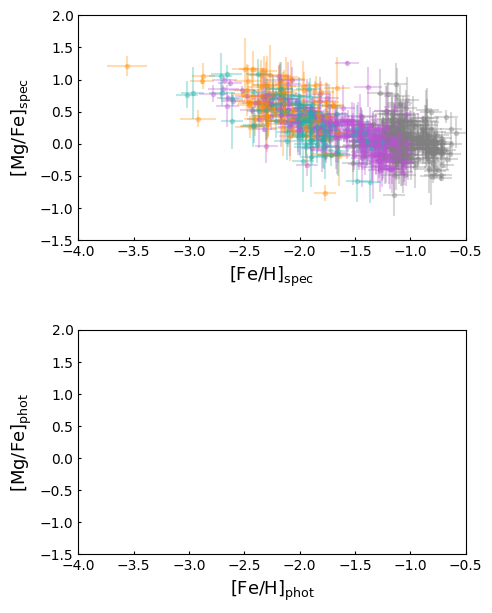

In [14]:
# Spec MGFE - FEH vs. phot MGFE - FEH
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(5,7), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 12 ; alpha = 0.3

ax0.errorbar(fnx_mag['FEH'], fnx_mag['MGFE'], xerr=fnx_mag['FEHERR'], yerr=fnx_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='gray')
ax0.errorbar(scl_mag['FEH'], scl_mag['MGFE'], xerr=scl_mag['FEHERR'], yerr=scl_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='mediumorchid')
ax0.errorbar(umi_mag['FEH'], umi_mag['MGFE'], xerr=umi_mag['FEHERR'], yerr=umi_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='darkorange')
ax0.errorbar(dra_mag['FEH'], dra_mag['MGFE'], xerr=dra_mag['FEHERR'], yerr=dra_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='lightseagreen')
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, -0.5])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)

# Photometry
ax1.errorbar(hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], xerr=hsc_fnx_mag['uncertainty_FEH_phot_ann'], yerr=hsc_fnx_mag['uncertainty_MGFE_phot_ann'], markersize=3, fmt='o', alpha=0.1, color='gray')
ax1.errorbar(hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], xerr=hsc_scl_mag['uncertainty_FEH_phot_ann'], yerr=hsc_scl_mag['uncertainty_MGFE_phot_ann'], markersize=3, fmt='o', alpha=0.1, color='mediumorchid')
ax1.errorbar(hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], xerr=hsc_umi_mag['uncertainty_FEH_phot_ann'], yerr=hsc_umi_mag['uncertainty_MGFE_phot_ann'], markersize=3, fmt='o', alpha=0.1, color='darkorange')
ax1.errorbar(hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], xerr=hsc_dra_mag['uncertainty_FEH_phot_ann'], yerr=hsc_dra_mag['uncertainty_MGFE_phot_ann'], markersize=3, fmt='o', alpha=0.1, color='lightseagreen')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax1.set_xlim([-4, -0.5])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)

plt.show()

In [43]:
predicted_fnx_FEH = slope_fnx * fnx_mag['FEH'] + intercept_fnx
predicted_hsc_fnx_FEH = slope_hsc_fnx * hsc_fnx_mag['FEH_phot_ann'] + intercept_hsc_fnx
predicted_scl_FEH = slope_scl * scl_mag['FEH'] + intercept_scl
predicted_hsc_scl_FEH = slope_hsc_scl * hsc_scl_mag['FEH_phot_ann'] + intercept_hsc_scl
predicted_umi_FEH = slope_umi * umi_mag['FEH'] + intercept_umi
predicted_hsc_umi_FEH = slope_hsc_umi * hsc_umi_mag['FEH_phot_ann'] + intercept_hsc_umi
predicted_dra_FEH = slope_dra * dra_mag['FEH'] + intercept_dra
predicted_hsc_dra_FEH = slope_hsc_dra * hsc_dra_mag['FEH_phot_ann'] + intercept_hsc_dra

predicted_fnx_MGFE = slope_fnx * fnx_mag['MGFE'] + intercept_fnx
predicted_hsc_fnx_MGFE = slope_hsc_fnx * hsc_fnx_mag['MGFE_phot_ann'] + intercept_hsc_fnx
predicted_scl_MGFE = slope_scl * scl_mag['MGFE'] + intercept_scl
predicted_hsc_scl_MGFE = slope_hsc_scl * hsc_scl_mag['MGFE_phot_ann'] + intercept_hsc_scl
predicted_umi_MGFE = slope_umi * umi_mag['MGFE'] + intercept_umi
predicted_hsc_umi_MGFE = slope_hsc_umi * hsc_umi_mag['MGFE_phot_ann'] + intercept_hsc_umi
predicted_dra_MGFE = slope_dra * dra_mag['MGFE'] + intercept_dra
predicted_hsc_dra_MGFE = slope_hsc_dra * hsc_dra_mag['MGFE_phot_ann'] + intercept_hsc_dra

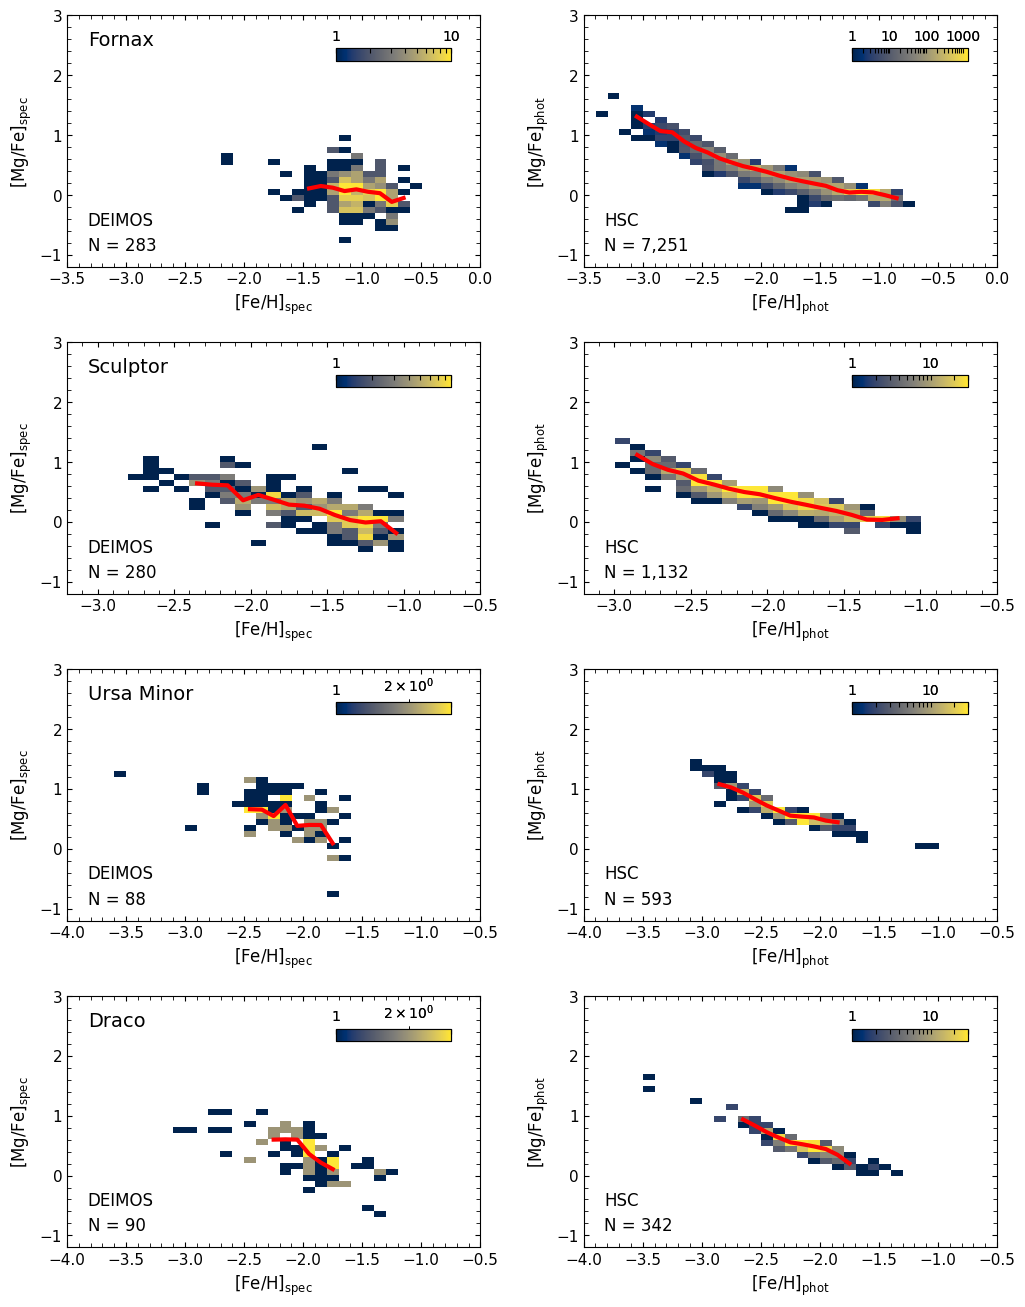

In [44]:
def plot_2d_histogram(ax, x, y, xlabel, ylabel, xlim, ylim, vmin=None, vmax=None, ticks=None):
    bins_width = 0.1
    xbins = np.arange(np.floor(np.min(x) / bins_width) * bins_width, 
                      np.ceil(np.max(x) / bins_width) * bins_width + bins_width, bins_width)
    ybins = np.arange(np.floor(np.min(y) / bins_width) * bins_width, 
                      np.ceil(np.max(y) / bins_width) * bins_width + bins_width, bins_width)

    counts, xedges, yedges = np.histogram2d(x, y, bins=(xbins, ybins))

    median_values = []
    for i in range(len(xedges) - 1):
        mask = (xedges[i] <= x) & (x < xedges[i+1])
        y_in_bin = y[mask]
        if len(y_in_bin) >= 5:
            median_values.append(np.median(y_in_bin))
        else:
            median_values.append(np.nan)

    xedges_centered = (xedges[:-1] + xedges[1:]) / 2
    median_values = median_values[:len(xedges_centered)]

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax.imshow(counts.T, cmap='cividis', origin='lower', extent=extent, aspect='auto', norm=LogNorm(vmin=vmin, vmax=vmax))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3.5, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=3, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3.5, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=3, labelsize=11)
    
    # Plot median line
    ax.plot(xedges_centered, median_values, color='red', label='Median', lw=3)

    # Add color bar
    cax = ax.inset_axes([0.65, 0.82, 0.28, 0.05])
    fig.add_axes(cax)
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=10, direction='in')
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.set_label('', size=11, labelpad=4, loc='center')
    cbar.locator = LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=5)
    cbar.formatter = LogFormatter(base=10.0, labelOnlyBase=True)
    if ticks:
        cbar.set_ticks(ticks)  # Add custom ticks
    cbar.update_ticks()

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16), gridspec_kw={'wspace': 0.25, 'hspace': 0.3})
(ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7) = axes

# Fornax
plot_2d_histogram(ax0, fnx_mag['FEH'], fnx_mag['MGFE'], r'[Fe/H]$_\mathrm{spec}$', r'[Mg/Fe]$_\mathrm{spec}$', [-3.5, 0], [-1.2, 3], vmin=1, vmax=10)
plot_2d_histogram(ax1, hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], r'[Fe/H]$_\mathrm{phot}$', r'[Mg/Fe]$_\mathrm{phot}$', [-3.5, 0], [-1.2, 3])
ax0.text(0.05, 0.94, 'Fornax', ha='left', va='top', transform=ax0.transAxes, size=14)
ax0.text(0.05, 0.15, 'DEIMOS', ha='left', va='bottom', transform=ax0.transAxes, size=12)
ax0.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(fnx_mag['FEH'])), ha='left', va='bottom', transform=ax0.transAxes, size=12)
ax1.text(0.05, 0.15, 'HSC', ha='left', va='bottom', transform=ax1.transAxes, size=12)
ax1.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(hsc_fnx_mag['FEH_phot_ann'])), ha='left', va='bottom', transform=ax1.transAxes, size=12)

# Sculptor
plot_2d_histogram(ax2, scl_mag['FEH'], scl_mag['MGFE'], r'[Fe/H]$_\mathrm{spec}$', r'[Mg/Fe]$_\mathrm{spec}$', [-3.2, -0.5], [-1.2, 3])
plot_2d_histogram(ax3, hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], r'[Fe/H]$_\mathrm{phot}$', r'[Mg/Fe]$_\mathrm{phot}$', [-3.2, -0.5], [-1.2, 3], vmin=1, vmax=30)
ax2.text(0.05, 0.94, 'Sculptor', ha='left', va='top', transform=ax2.transAxes, size=14)
ax2.text(0.05, 0.15, 'DEIMOS', ha='left', va='bottom', transform=ax2.transAxes, size=12)
ax2.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(scl_mag['FEH'])), ha='left', va='bottom', transform=ax2.transAxes, size=12)
ax3.text(0.05, 0.15, 'HSC', ha='left', va='bottom', transform=ax3.transAxes, size=12)
ax3.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(hsc_scl_mag['FEH_phot_ann'])), ha='left', va='bottom', transform=ax3.transAxes, size=12)

# Ursa Minor
plot_2d_histogram(ax4, umi_mag['FEH'], umi_mag['MGFE'], r'[Fe/H]$_\mathrm{spec}$', r'[Mg/Fe]$_\mathrm{spec}$', [-4, -0.5], [-1.2, 3], vmin=1, vmax=3, ticks=[1, 3])
plot_2d_histogram(ax5, hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], r'[Fe/H]$_\mathrm{phot}$', r'[Mg/Fe]$_\mathrm{phot}$', [-4, -0.5], [-1.2, 3], vmin=1, vmax=30)
ax4.text(0.05, 0.94, 'Ursa Minor', ha='left', va='top', transform=ax4.transAxes, size=14)
ax4.text(0.05, 0.15, 'DEIMOS', ha='left', va='bottom', transform=ax4.transAxes, size=12)
ax4.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(umi_mag['FEH'])), ha='left', va='bottom', transform=ax4.transAxes, size=12)
#cbar.set_ticks([1, 3])
ax5.text(0.05, 0.15, 'HSC', ha='left', va='bottom', transform=ax5.transAxes, size=12)
ax5.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(hsc_umi_mag['FEH_phot_ann'])), ha='left', va='bottom', transform=ax5.transAxes, size=12)

# Draco
plot_2d_histogram(ax6, dra_mag['FEH'], dra_mag['MGFE'], r'[Fe/H]$_\mathrm{spec}$', r'[Mg/Fe]$_\mathrm{spec}$', [-4, -0.5], [-1.2, 3], vmin=1, vmax=3, ticks=[1, 3])
plot_2d_histogram(ax7, hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], r'[Fe/H]$_\mathrm{phot}$', r'[Mg/Fe]$_\mathrm{phot}$', [-4, -0.5], [-1.2, 3], vmin=1, vmax=30)
ax6.text(0.05, 0.94, 'Draco', ha='left', va='top', transform=ax6.transAxes, size=14)
ax6.text(0.05, 0.15, 'DEIMOS', ha='left', va='bottom', transform=ax6.transAxes, size=12)
ax6.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(dra_mag['FEH'])), ha='left', va='bottom', transform=ax6.transAxes, size=12)
ax7.text(0.05, 0.15, 'HSC', ha='left', va='bottom', transform=ax7.transAxes, size=12)
ax7.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(hsc_dra_mag['FEH_phot_ann'])), ha='left', va='bottom', transform=ax7.transAxes, size=12)


plt.savefig('compare_ann_spec_phot_mgfe_feh_hist2d_medianline.png', bbox_inches='tight')

In [45]:
def get_median_mgfe(feh_values, mgfe_values, bin_width=0.1):
    bins = np.arange(np.floor(np.min(feh_values) / bin_width) * bin_width, 
                     np.ceil(np.max(feh_values) / bin_width) * bin_width + bin_width, bin_width)
    #print(bins) #[-2.2 -2.1 -2. -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1. -0.9 -0.8 -0.7 -0.6 -0.5]
    
    median_mgfe_dict = {}
    for i in range(len(bins) - 1):
        mask = (bins[i] <= feh_values) & (feh_values < bins[i + 1])
        if np.sum(mask) >= 5:  # get median value if there are 5 data at least
            median_mgfe_dict[(bins[i], bins[i + 1])] = np.median(mgfe_values[mask])
        else:
            median_mgfe_dict[(bins[i], bins[i + 1])] = np.nan  # NaN if there are less than 5 stars
    
    return median_mgfe_dict

# Get median MGFE value per FEH 0.1 bin
median_mgfe_bins = get_median_mgfe(fnx_mag['FEH'], fnx_mag['MGFE'])

# Get predicted MGFE values
# Assign the median MGFE value of the corresponding FEH bin as the predicted value for each data point.
predicted_fnx_MGFE = np.array([
    median_mgfe_bins.get(
        next(((b1, b2) for (b1, b2) in median_mgfe_bins if b1 <= feh < b2), None),
        np.nan
    ) for feh in fnx_mag['FEH']
])
#print(predicted_fnx_MGFE)

"""def calculate_err_sys(mgfe, fitted_mgfe, err_mgfe, N):
    def equation(err_sys):
        #numerator = np.sum((mgfe - fitted_mgfe)**2)
        #denominator = np.sum(err_mgfe**2) + (err_sys**2)
        numerator = (mgfe - fitted_mgfe)**2
        denominator = err_mgfe**2 + err_sys**2
        result = np.sum(numerator / denominator) / N
        print(f"numerator: {numerator}, denominator: {denominator}, result: {result}")
        
        return result - 1
   
    err_sys_initial = 0.1
    err_sys_solution = fsolve(equation, err_sys_initial)[0]
    print('err_sys_solution =', np.abs(err_sys_solution))

    return err_sys_solution

err_sys_1 = calculate_err_sys(fnx_mag['MGFE'], predicted_fnx_MGFE, fnx_mag['MGFEERR'], len(fnx_mag['MGFE']))

err_sys_2 = calculate_err_sys(hsc_fnx_mag['MGFE_phot_ann'], predicted_hsc_fnx_MGFE, hsc_fnx_mag['uncertainty_MGFE_phot_ann'], len(hsc_fnx_mag['MGFE_phot_ann']))
"""

from scipy.optimize import minimize
def calculate_err_sys(mgfe, fitted_mgfe, err_mgfe, N):
    def objective(err_sys):
        numerator = (mgfe - fitted_mgfe)**2
        denominator = err_mgfe**2 + err_sys[0]**2
        result = np.sum(numerator / denominator) / N
        #print(f"numerator: {numerator}, denominator: {denominator}, result: {result}")
        return (result - 1)**2  #minimize

    initial_guess = [0.1]
    bounds = [(0, None)]
    
    result = minimize(objective, x0=initial_guess, bounds=bounds)
    
    err_sys_solution = result.x[0]
    print(f"err_sys_solution: {err_sys_solution}")
    return err_sys_solution

sys_err_fnx = calculate_err_sys(fnx_mag['MGFE'], predicted_fnx_MGFE, fnx_mag['MGFEERR'], len(fnx_mag['MGFE']))
sys_err_hsc_fnx = calculate_err_sys(hsc_fnx_mag['MGFE_phot_ann'], predicted_hsc_fnx_MGFE, hsc_fnx_mag['uncertainty_MGFE_phot_ann'], len(hsc_fnx_mag['MGFE_phot_ann']))

err_sys_solution: 0.14317656398425804
err_sys_solution: 0.8267770935875358


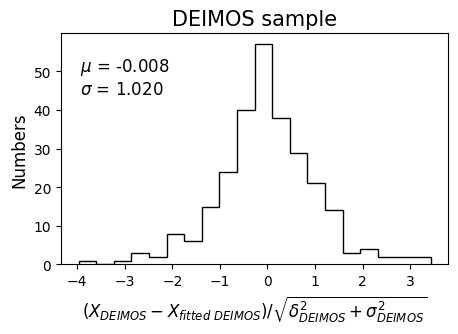

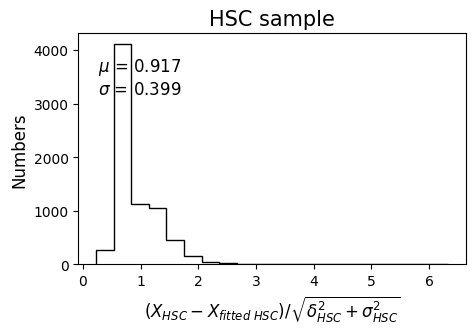

In [46]:
fig, ax0 = plt.subplots(figsize=(5,3))
x = (fnx_mag['MGFE'] - predicted_fnx_MGFE) / np.sqrt(fnx_mag['MGFEERR']**2 + sys_err_fnx**2)
ax0.hist(x, bins=20, color='k', histtype='step')
ax0.set_title('DEIMOS sample', size=15)
ax0.set_xlabel(r'$(X_{DEIMOS} - X_{fitted~DEIMOS}) / \sqrt{\delta_{DEIMOS}^2 + \sigma_{DEIMOS}^2}$', size=12)
ax0.set_ylabel('Numbers', size=12)
ax0.text(0.05, 0.9, '$\mu$ = {0:,.3f}'.format(np.mean(x)), ha='left', va='top', transform=ax0.transAxes, size=12)
ax0.text(0.05, 0.8, '$\sigma$ = {0:,.3f}'.format(np.std(x)), ha='left', va='top', transform=ax0.transAxes, size=12)
plt.show()

print('\n')

fig, ax0 = plt.subplots(figsize=(5,3))
x = (hsc_fnx_mag['MGFE_phot_ann'] - predicted_hsc_fnx_MGFE) / np.sqrt(hsc_fnx_mag['uncertainty_MGFE_phot_ann']**2 + sys_err_hsc_fnx**2)
ax0.hist(x, bins=20, color='k', histtype='step')
ax0.set_title('HSC sample', size=15)
ax0.set_xlabel(r'$(X_{HSC} - X_{fitted~HSC}) / \sqrt{\delta_{HSC}^2 + \sigma_{HSC}^2}$', size=12)
ax0.set_ylabel('Numbers', size=12)
ax0.text(0.05, 0.9, '$\mu$ = {0:,.3f}'.format(np.mean(x)), ha='left', va='top', transform=ax0.transAxes, size=12)
ax0.text(0.05, 0.8, '$\sigma$ = {0:,.3f}'.format(np.std(x)), ha='left', va='top', transform=ax0.transAxes, size=12)
plt.show()

In [49]:
fnx_mag_sigma = fnx_mag[(np.abs(fnx_mag['FEH'] - np.mean(fnx_mag['FEH'])) - fnx_mag['FEHERR'] < 3 * fnx_mag['FEHERR']) & (np.abs(fnx_mag['MGFE'] - np.mean(fnx_mag['MGFE'])) - fnx_mag['MGFEERR'] < 3 * fnx_mag['MGFEERR'])]
print(len(fnx_mag)) #
print(len(fnx_mag_sigma), '\n') #

scl_mag_sigma = scl_mag[(np.abs(scl_mag['FEH'] - np.mean(scl_mag['FEH'])) - scl_mag['FEHERR'] < 3 * scl_mag['FEHERR']) & (np.abs(scl_mag['MGFE'] - np.mean(scl_mag['MGFE'])) - scl_mag['MGFEERR'] < 3 * scl_mag['MGFEERR'])]
print(len(scl_mag)) #
print(len(scl_mag_sigma), '\n') #

umi_mag_sigma = umi_mag[(np.abs(umi_mag['FEH'] - np.mean(umi_mag['FEH'])) - umi_mag['FEHERR'] < 3 * umi_mag['FEHERR']) & (np.abs(umi_mag['MGFE'] - np.mean(umi_mag['MGFE'])) - umi_mag['MGFEERR'] < 3 * umi_mag['MGFEERR'])]
print(len(umi_mag)) #
print(len(umi_mag_sigma), '\n') #

dra_mag_sigma = dra_mag[(np.abs(dra_mag['FEH'] - np.mean(dra_mag['FEH'])) - dra_mag['FEHERR'] < 3 * dra_mag['FEHERR']) & (np.abs(dra_mag['MGFE'] - np.mean(dra_mag['MGFE'])) - dra_mag['MGFEERR'] < 3 * dra_mag['MGFEERR'])]
print(len(dra_mag)) #
print(len(dra_mag_sigma), '\n') #


hsc_fnx_mag_sigma = hsc_fnx_mag[(np.abs(hsc_fnx_mag['FEH_phot_ann'] - np.mean(hsc_fnx_mag['FEH_phot_ann'])) - hsc_fnx_mag['uncertainty_FEH_phot_ann'] < 3 * hsc_fnx_mag['uncertainty_FEH_phot_ann']) & (np.abs(hsc_fnx_mag['MGFE_phot_ann'] - np.mean(hsc_fnx_mag['MGFE_phot_ann'])) - hsc_fnx_mag['uncertainty_MGFE_phot_ann'] < 3 * hsc_fnx_mag['uncertainty_MGFE_phot_ann'])]
print(len(hsc_fnx_mag)) #
print(len(hsc_fnx_mag_sigma), '\n') #

hsc_scl_mag_sigma = hsc_scl_mag[(np.abs(hsc_scl_mag['FEH_phot_ann'] - np.mean(hsc_scl_mag['FEH_phot_ann'])) - hsc_scl_mag['uncertainty_FEH_phot_ann'] < 3 * hsc_scl_mag['uncertainty_FEH_phot_ann']) & (np.abs(hsc_scl_mag['MGFE_phot_ann'] - np.mean(hsc_scl_mag['MGFE_phot_ann'])) - hsc_scl_mag['uncertainty_MGFE_phot_ann'] < 3 * hsc_scl_mag['uncertainty_MGFE_phot_ann'])]
print(len(hsc_scl_mag)) #
print(len(hsc_scl_mag_sigma), '\n') #

hsc_umi_mag_sigma = hsc_umi_mag[(np.abs(hsc_umi_mag['FEH_phot_ann'] - np.mean(hsc_umi_mag['FEH_phot_ann'])) - hsc_umi_mag['uncertainty_FEH_phot_ann'] < 3 * hsc_umi_mag['uncertainty_FEH_phot_ann']) & (np.abs(hsc_umi_mag['MGFE_phot_ann'] - np.mean(hsc_umi_mag['MGFE_phot_ann'])) - hsc_umi_mag['uncertainty_MGFE_phot_ann'] < 3 * hsc_umi_mag['uncertainty_MGFE_phot_ann'])]
print(len(hsc_umi_mag)) #
print(len(hsc_umi_mag_sigma), '\n') #

hsc_dra_mag_sigma = hsc_dra_mag[(np.abs(hsc_dra_mag['FEH_phot_ann'] - np.mean(hsc_dra_mag['FEH_phot_ann'])) - hsc_dra_mag['uncertainty_FEH_phot_ann'] < 3 * hsc_dra_mag['uncertainty_FEH_phot_ann']) & (np.abs(hsc_dra_mag['MGFE_phot_ann'] - np.mean(hsc_dra_mag['MGFE_phot_ann'])) - hsc_dra_mag['uncertainty_MGFE_phot_ann'] < 3 * hsc_dra_mag['uncertainty_MGFE_phot_ann'])]
print(len(hsc_dra_mag)) #
print(len(hsc_dra_mag_sigma)) #

283
235 

280
169 

88
70 

90
64 

7251
0 

1132
0 

593
0 

342
0


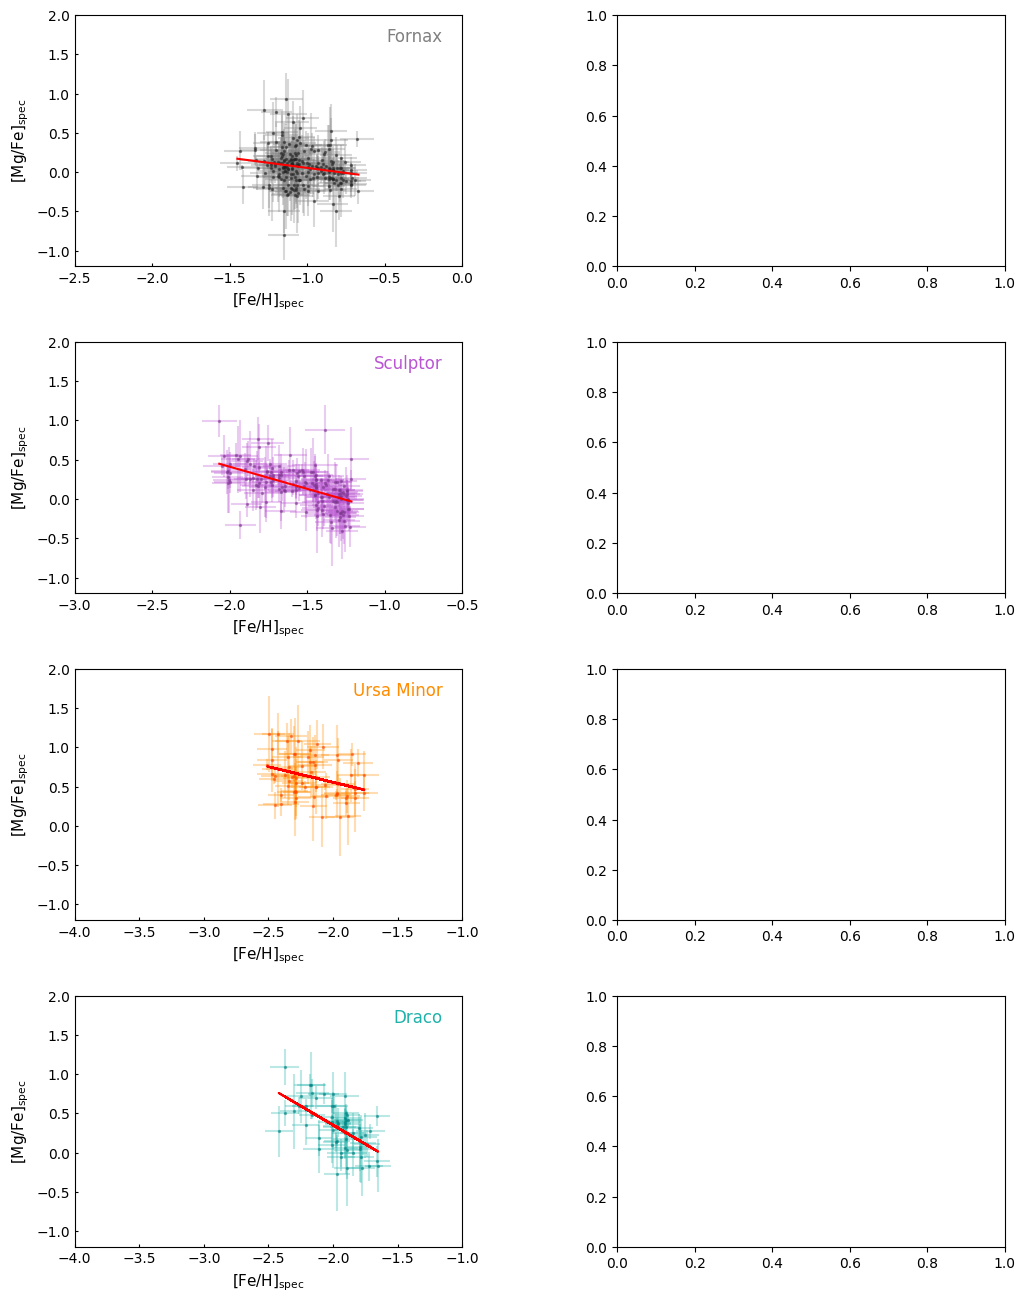

In [50]:
# Spec MGFE - FEH vs. phot MGFE - FEH
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(nrows=4, ncols=2, figsize=(12,16), gridspec_kw={'wspace':0.4, 'hspace':0.3})
s = 2 ; alpha = 0.5 ; markersize=0

# Fnx
ax0.errorbar(fnx_mag_sigma['FEH'], fnx_mag_sigma['MGFE'], xerr=fnx_mag_sigma['FEHERR'], yerr=fnx_mag_sigma['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='gray')
ax0.scatter(fnx_mag_sigma['FEH'], fnx_mag_sigma['MGFE'], s=s, alpha=alpha, marker='o', color='#222222', zorder=2)
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax0.set_xlim([-2.5, 0])
ax0.set_ylim([-1.2, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.95, 0.95, 'Fornax', ha='right', va='top', transform=ax0.transAxes, color='gray', size=12)
slope, intercept = np.polyfit(fnx_mag_sigma['FEH'], fnx_mag_sigma['MGFE'], 1)
ax0.plot(fnx_mag_sigma['FEH'], slope * fnx_mag_sigma['FEH'] + intercept, color='red', lw=1.5, label='Trendline')

#ax1.errorbar(hsc_fnx_mag_sigma['FEH_phot_ann'], hsc_fnx_mag_sigma['MGFE_phot_ann'], xerr=hsc_fnx_mag_sigma['uncertainty_FEH_phot_ann'], yerr=hsc_fnx_mag_sigma['uncertainty_MGFE_phot_ann'], markersize=markersize, fmt='o', alpha=0.1, color='gray')
#ax1.scatter(hsc_fnx_mag_sigma['FEH_phot_ann'], hsc_fnx_mag_sigma['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#222222', zorder=2)
#ax1.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
#ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
#ax1.set_xlim([-2.5, 0])
#ax1.set_ylim([-1.2, 2])
#ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
#ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
#ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
#ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
#slope, intercept = np.polyfit(hsc_fnx_mag_sigma['FEH_phot_ann'], hsc_fnx_mag_sigma['MGFE_phot_ann'], 1)
#ax1.plot(hsc_fnx_mag_sigma['FEH_phot_ann'], slope * hsc_fnx_mag_sigma['FEH_phot_ann'] + intercept, color='red', lw=1.5, label='Trendline')


# Scl
ax2.errorbar(scl_mag_sigma['FEH'], scl_mag_sigma['MGFE'], xerr=scl_mag_sigma['FEHERR'], yerr=scl_mag_sigma['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='mediumorchid')
ax2.scatter(scl_mag_sigma['FEH'], scl_mag_sigma['MGFE'], s=s, alpha=alpha, marker='o', color='#7A378B', zorder=2)
ax2.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax2.set_xlim([-3, -0.5])
ax2.set_ylim([-1.2, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.95, 0.95, 'Sculptor', ha='right', va='top', transform=ax2.transAxes, color='mediumorchid', size=12)
slope, intercept = np.polyfit(scl_mag_sigma['FEH'], scl_mag_sigma['MGFE'], 1)
ax2.plot(scl_mag_sigma['FEH'], slope * scl_mag_sigma['FEH'] + intercept, color='red', lw=1.5, label='Trendline')

#ax3.errorbar(hsc_scl_mag_sigma['FEH_phot_ann'], hsc_scl_mag_sigma['MGFE_phot_ann'], xerr=hsc_scl_mag_sigma['uncertainty_FEH_phot_ann'], yerr=hsc_scl_mag_sigma['uncertainty_MGFE_phot_ann'], markersize=markersize, fmt='o', alpha=0.1, color='mediumorchid')
#ax3.scatter(hsc_scl_mag_sigma['FEH_phot_ann'], hsc_scl_mag_sigma['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#7A378B', zorder=2)
#ax3.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
#ax3.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
#ax3.set_xlim([-3, -0.5])
#ax3.set_ylim([-1.2, 2])
#ax3.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
#ax3.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
#ax3.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
#ax3.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
#slope, intercept = np.polyfit(hsc_scl_mag_sigma['FEH_phot_ann'], hsc_scl_mag_sigma['MGFE_phot_ann'], 1)
#ax3.plot(hsc_scl_mag_sigma['FEH_phot_ann'], slope * hsc_scl_mag_sigma['FEH_phot_ann'] + intercept, color='red', lw=1.5, label='Trendline')


# UMi
ax4.errorbar(umi_mag_sigma['FEH'], umi_mag_sigma['MGFE'], xerr=umi_mag_sigma['FEHERR'], yerr=umi_mag_sigma['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='darkorange')
ax4.scatter(umi_mag_sigma['FEH'], umi_mag_sigma['MGFE'], s=s, alpha=alpha, marker='o', color='#FF4500', zorder=2)
ax4.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax4.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax4.set_xlim([-4, -1])
ax4.set_ylim([-1.2, 2])
ax4.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax4.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax4.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax4.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax4.text(0.95, 0.95, 'Ursa Minor', ha='right', va='top', transform=ax4.transAxes, color='darkorange', size=12)
slope, intercept = np.polyfit(umi_mag_sigma['FEH'], umi_mag_sigma['MGFE'], 1)
ax4.plot(umi_mag_sigma['FEH'], slope * umi_mag_sigma['FEH'] + intercept, color='red', lw=1.5, label='Trendline')

#ax5.errorbar(hsc_umi_mag_sigma['FEH_phot_ann'], hsc_umi_mag_sigma['MGFE_phot_ann'], xerr=hsc_umi_mag_sigma['uncertainty_FEH_phot_ann'], yerr=hsc_umi_mag_sigma['uncertainty_MGFE_phot_ann'], markersize=markersize, fmt='o', alpha=0.1, color='darkorange')
#ax5.scatter(hsc_umi_mag_sigma['FEH_phot_ann'], hsc_umi_mag_sigma['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#FF4500', zorder=2)
#ax5.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
#ax5.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
#ax5.set_xlim([-4, -1])
#ax5.set_ylim([-1.2, 2])
#ax5.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
#ax5.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
#ax5.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
#ax5.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
#slope, intercept = np.polyfit(hsc_umi_mag_sigma['FEH_phot_ann'], hsc_umi_mag_sigma['MGFE_phot_ann'], 1)
#ax5.plot(hsc_umi_mag_sigma['FEH_phot_ann'], slope * hsc_umi_mag_sigma['FEH_phot_ann'] + intercept, color='red', lw=1.5, label='Trendline')


# Dra
ax6.errorbar(dra_mag_sigma['FEH'], dra_mag_sigma['MGFE'], xerr=dra_mag_sigma['FEHERR'], yerr=dra_mag_sigma['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='lightseagreen')
ax6.scatter(dra_mag_sigma['FEH'], dra_mag_sigma['MGFE'], s=s, alpha=alpha, marker='o', color='#008080', zorder=2)
ax6.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax6.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax6.set_xlim([-4, -1])
ax6.set_ylim([-1.2, 2])
ax6.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax6.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax6.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax6.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax6.text(0.95, 0.95, 'Draco', ha='right', va='top', transform=ax6.transAxes, color='lightseagreen', size=12)
slope, intercept = np.polyfit(dra_mag_sigma['FEH'], dra_mag_sigma['MGFE'], 1)
ax6.plot(dra_mag_sigma['FEH'], slope * dra_mag_sigma['FEH'] + intercept, color='red', lw=1.5, label='Trendline')

#ax7.errorbar(hsc_dra_mag_sigma['FEH_phot_ann'], hsc_dra_mag_sigma['MGFE_phot_ann'], xerr=hsc_dra_mag_sigma['uncertainty_FEH_phot_ann'], yerr=hsc_dra_mag_sigma['uncertainty_MGFE_phot_ann'], markersize=markersize, fmt='o', alpha=0.1, color='lightseagreen')
#ax7.scatter(hsc_dra_mag_sigma['FEH_phot_ann'], hsc_dra_mag_sigma['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#008080', zorder=2)
#ax7.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
#ax7.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
#ax7.set_xlim([-4, -1])
#ax7.set_ylim([-1.2, 2])
#ax7.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
#ax7.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
#ax7.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
#ax7.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
#slope, intercept = np.polyfit(hsc_dra_mag_sigma['FEH_phot_ann'], hsc_dra_mag_sigma['MGFE_phot_ann'], 1)
#ax7.plot(hsc_dra_mag_sigma['FEH_phot_ann'], slope * hsc_dra_mag_sigma['FEH_phot_ann'] + intercept, color='red', lw=1.5, label='Trendline')

#plt.show()
plt.savefig('compare_ann_spec_phot_mgfe_feh_w_line.png', bbox_inches='tight')

In [ ]:
# Simple comparison version

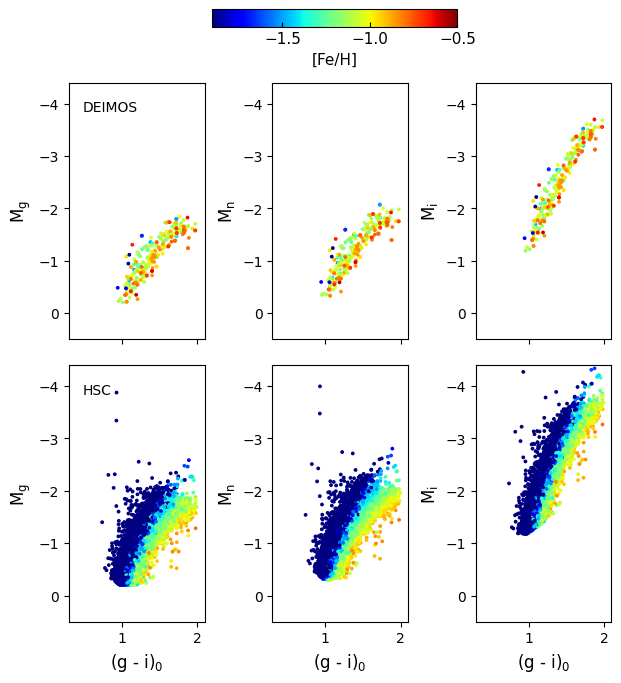

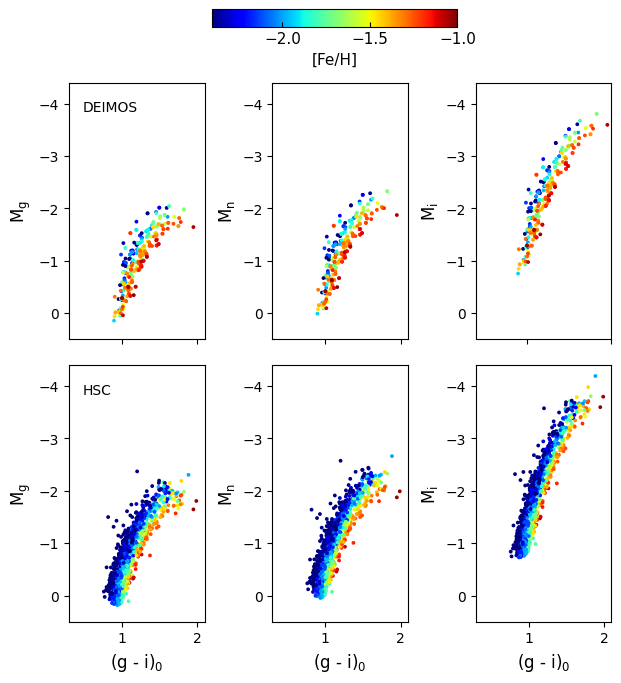

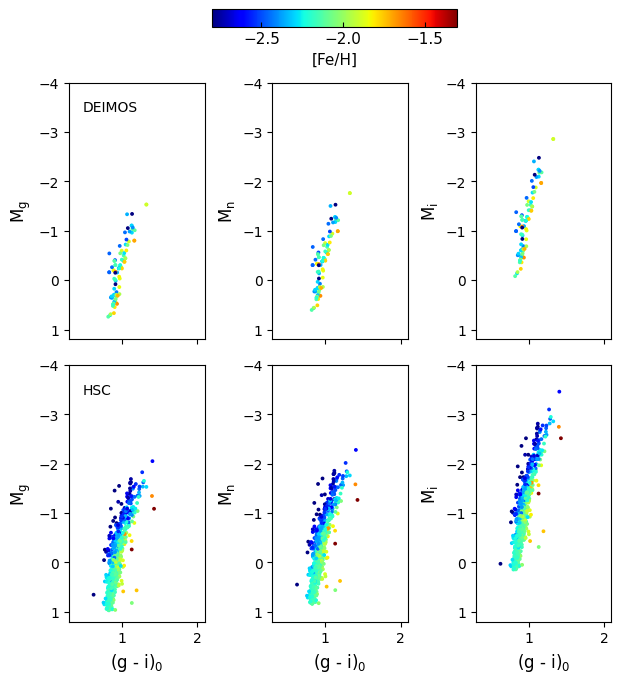

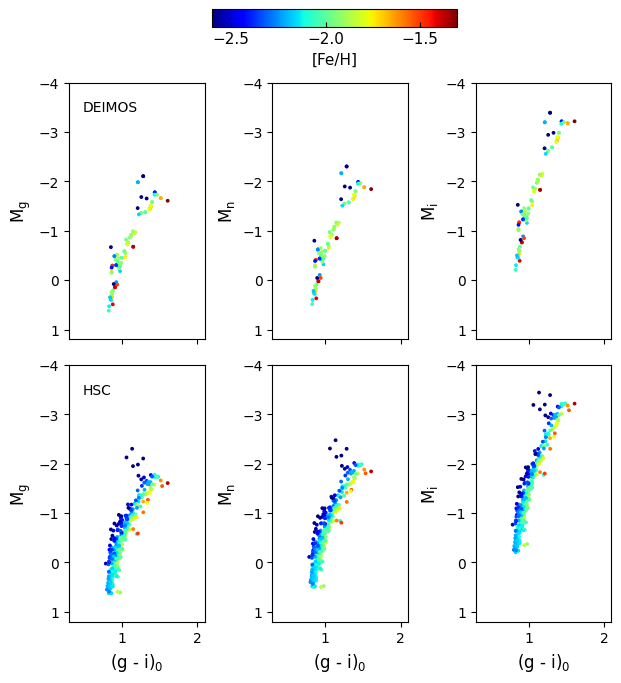

In [53]:
# Fornax
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
xmin = 0.3 ; xmax = 2.1
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
#ax0.grid()
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mi0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mi0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)
plt.savefig('cmd_deimos_hsc_feh_Fornax.png', bbox_inches='tight')



# Sculptor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -2.4 ; vmax = -1
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mg0'], marker='o', s=s, c=scl_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'], marker='o', s=s, c=scl_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mi0'], marker='o', s=s, c=scl_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'], marker='o', s=s, c=hsc_scl_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mi0'], marker='o', s=s, c=hsc_scl_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)
plt.savefig('cmd_deimos_hsc_feh_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -2.8 ; vmax = -1.3
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mg0'], marker='o', s=s, c=umi_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'], marker='o', s=s, c=umi_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mi0'], marker='o', s=s, c=umi_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'], marker='o', s=s, c=hsc_umi_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mi0'], marker='o', s=s, c=hsc_umi_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)
plt.savefig('cmd_deimos_hsc_feh_Ursaminor.png', bbox_inches='tight')


# Draco
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -2.6 ; vmax = -1.3
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mg0'], marker='o', s=s, c=dra_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'], marker='o', s=s, c=dra_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mi0'], marker='o', s=s, c=dra_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'], marker='o', s=s, c=hsc_dra_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mi0'], marker='o', s=s, c=hsc_dra_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)
plt.savefig('cmd_deimos_hsc_feh_Draco.png', bbox_inches='tight')

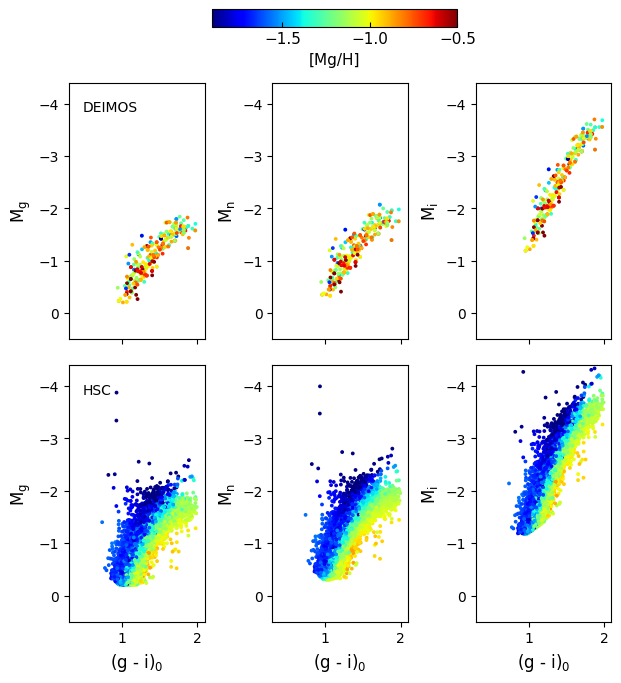

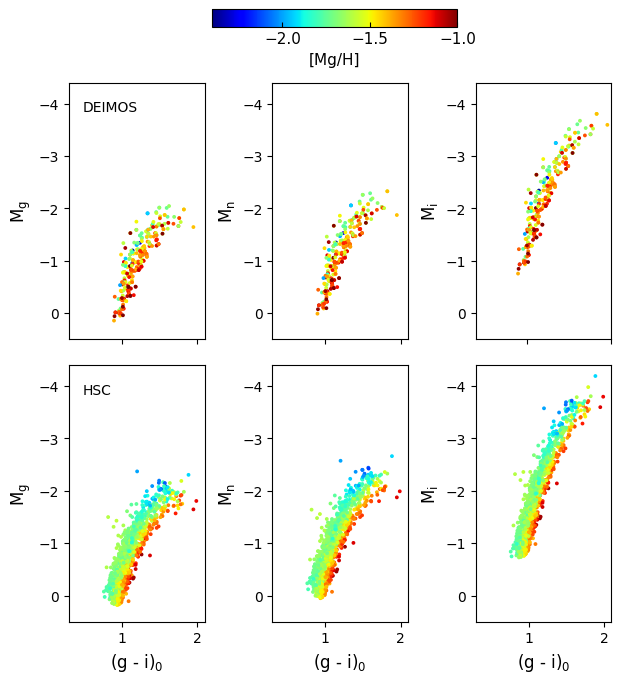

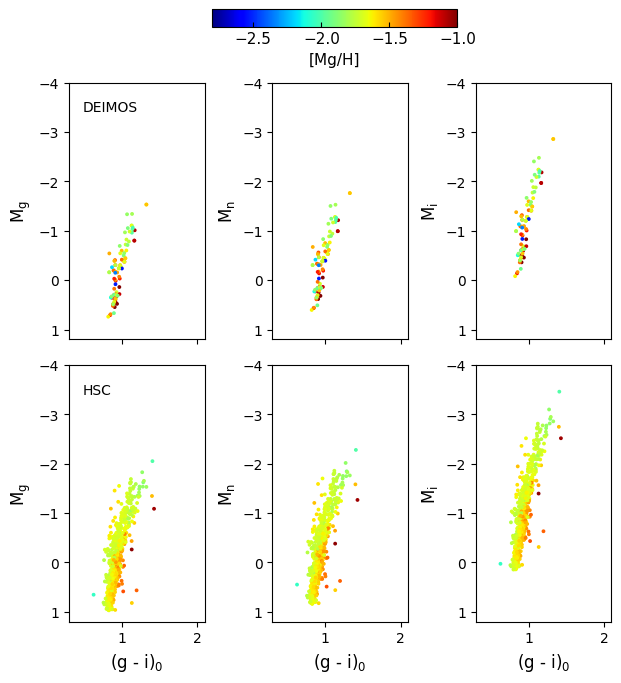

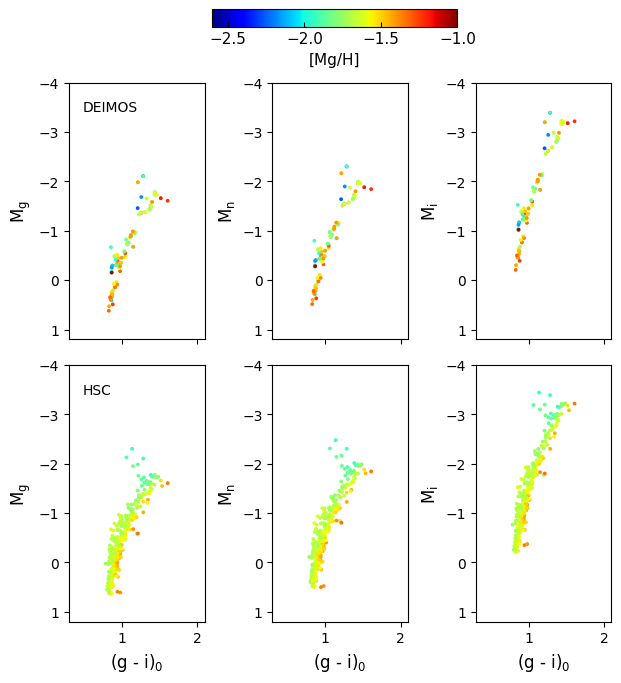

In [54]:
# Fornax
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
xmin = 0.3 ; xmax = 2.1
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
#ax0.grid()
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'], marker='o', s=s, c=fnx_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mi0'], marker='o', s=s, c=fnx_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'], marker='o', s=s, c=hsc_fnx_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mi0'], marker='o', s=s, c=hsc_fnx_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/H]', size=11)
plt.savefig('cmd_deimos_hsc_mgh_Fornax.png', bbox_inches='tight')



# Sculptor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -2.4 ; vmax = -1
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mi0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'], marker='o', s=s, c=hsc_scl_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mi0'], marker='o', s=s, c=hsc_scl_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/H]', size=11)
plt.savefig('cmd_deimos_hsc_mgh_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -2.8 ; vmax = -1
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mg0'], marker='o', s=s, c=umi_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'], marker='o', s=s, c=umi_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mi0'], marker='o', s=s, c=umi_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'], marker='o', s=s, c=hsc_umi_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mi0'], marker='o', s=s, c=hsc_umi_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/H]', size=11)
plt.savefig('cmd_deimos_hsc_mgh_Ursaminor.png', bbox_inches='tight')


# Draco
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -2.6 ; vmax = -1
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mg0'], marker='o', s=s, c=dra_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'], marker='o', s=s, c=dra_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mi0'], marker='o', s=s, c=dra_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'], marker='o', s=s, c=hsc_dra_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mi0'], marker='o', s=s, c=hsc_dra_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/H]', size=11)
plt.savefig('cmd_deimos_hsc_mgh_Draco.png', bbox_inches='tight')

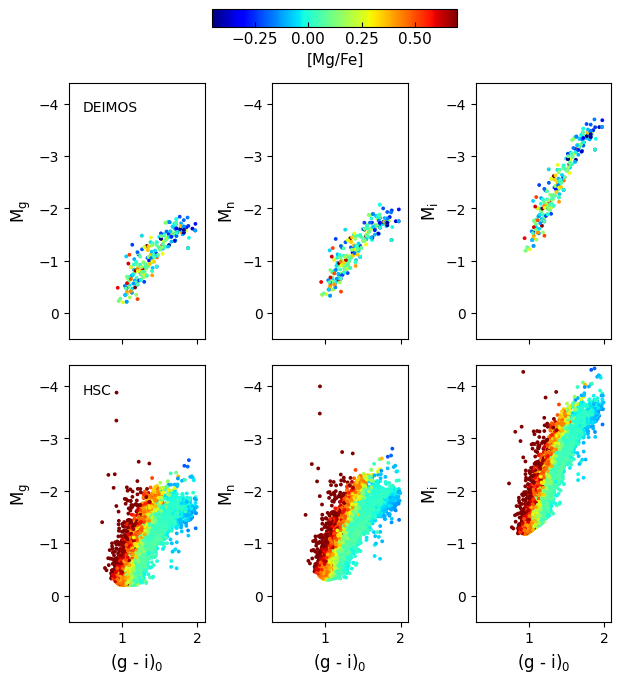

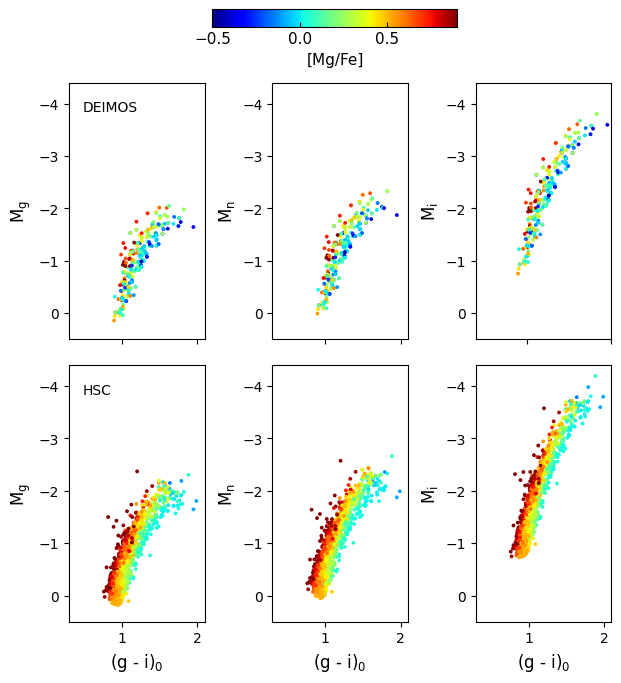

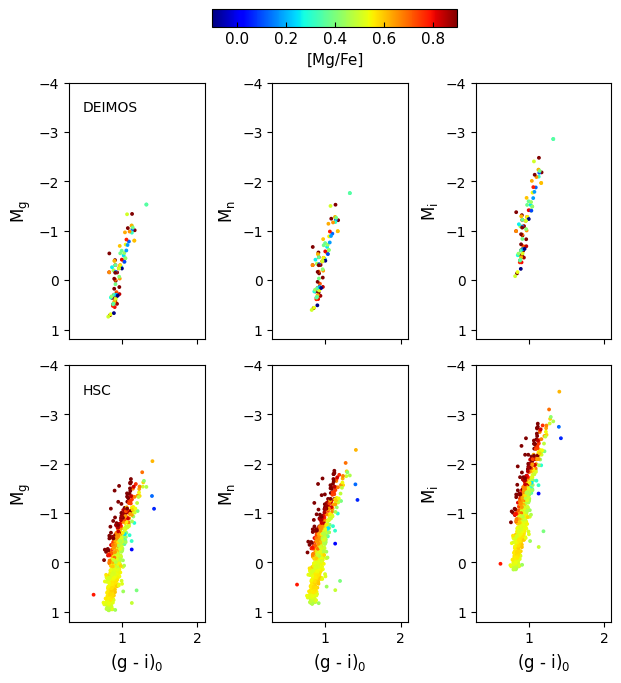

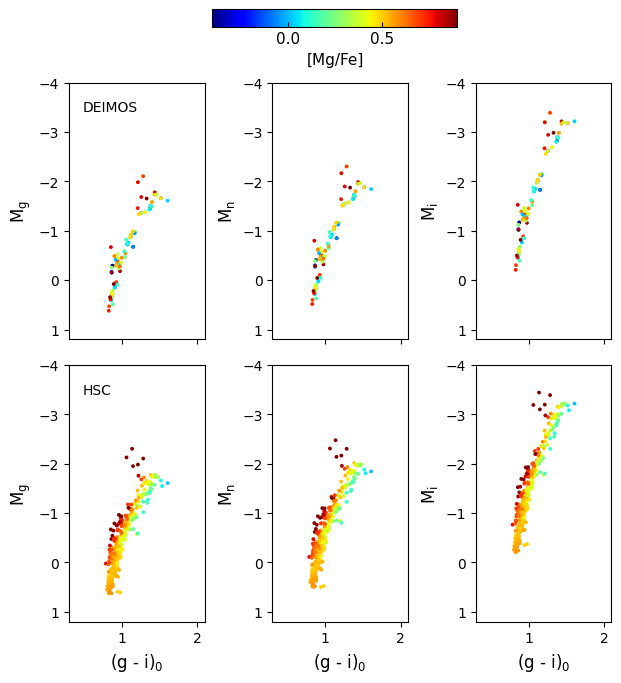

In [55]:
# Fornax
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
xmin = 0.3 ; xmax = 2.1
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -0.45 ; vmax = 0.7
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
#ax0.grid()
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'], marker='o', s=s, c=fnx_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mi0'], marker='o', s=s, c=fnx_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'], marker='o', s=s, c=hsc_fnx_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mi0'], marker='o', s=s, c=hsc_fnx_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/Fe]', size=11)
plt.savefig('cmd_deimos_hsc_mgfe_Fornax.png', bbox_inches='tight')



# Sculptor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -0.5 ; vmax =0.9
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'], marker='o', s=s, c=scl_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mi0'], marker='o', s=s, c=scl_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'], marker='o', s=s, c=hsc_scl_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mi0'], marker='o', s=s, c=hsc_scl_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/Fe]', size=11)
plt.savefig('cmd_deimos_hsc_mgfe_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -0.1 ; vmax = 0.9
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mg0'], marker='o', s=s, c=umi_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'], marker='o', s=s, c=umi_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mi0'], marker='o', s=s, c=umi_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'], marker='o', s=s, c=hsc_umi_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mi0'], marker='o', s=s, c=hsc_umi_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/Fe]', size=11)
plt.savefig('cmd_deimos_hsc_mgfe_Ursaminor.png', bbox_inches='tight')


# Draco
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -0.4 ; vmax = 0.9
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mg0'], marker='o', s=s, c=dra_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'], marker='o', s=s, c=dra_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mi0'], marker='o', s=s, c=dra_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'], marker='o', s=s, c=hsc_dra_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mi0'], marker='o', s=s, c=hsc_dra_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/Fe]', size=11)
plt.savefig('cmd_deimos_hsc_mgfe_Draco.png', bbox_inches='tight')

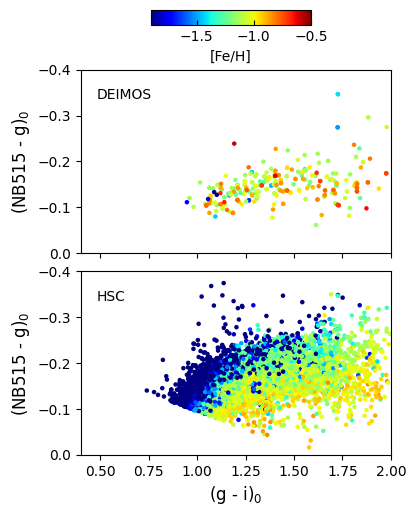

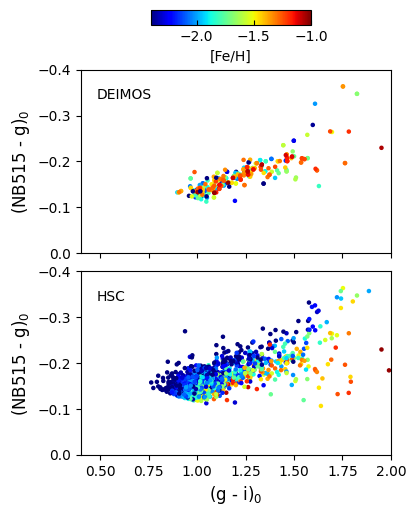

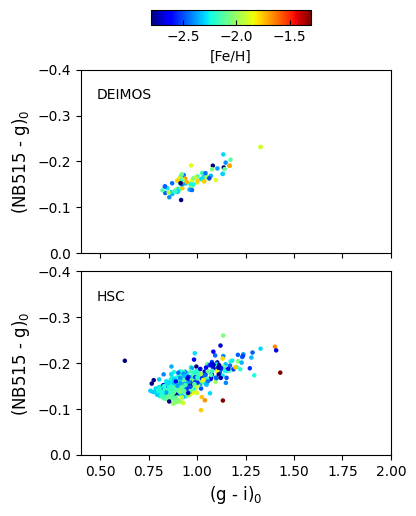

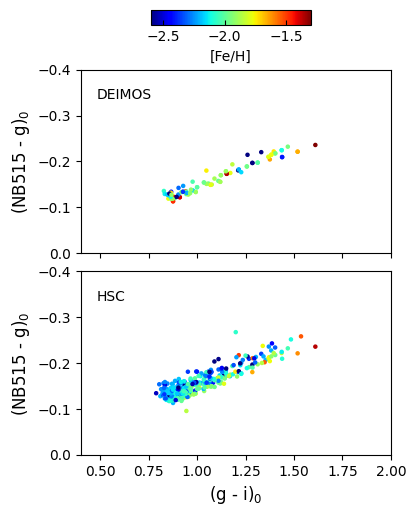

In [56]:
# Fornax
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'] - fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'] - hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Fe/H]', size=10)
plt.savefig('ccd_deimos_hsc_feh_Fornax.png', bbox_inches='tight')

# Sculptor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.4 ; vmax = -1
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'] - scl_mag['Mg0'], marker='o', s=s, c=scl_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'] - hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Fe/H]', size=10)
plt.savefig('ccd_deimos_hsc_feh_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.8 ; vmax = -1.3
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'] - umi_mag['Mg0'], marker='o', s=s, c=umi_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'] - hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Fe/H]', size=10)
plt.savefig('ccd_deimos_hsc_feh_Ursaminor.png', bbox_inches='tight')


# Draco
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.6 ; vmax = -1.3
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'] - dra_mag['Mg0'], marker='o', s=s, c=dra_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'] - hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Fe/H]', size=10)
plt.savefig('ccd_deimos_hsc_feh_Draco.png', bbox_inches='tight')

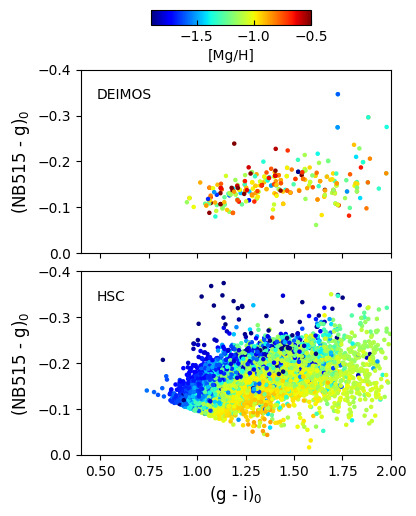

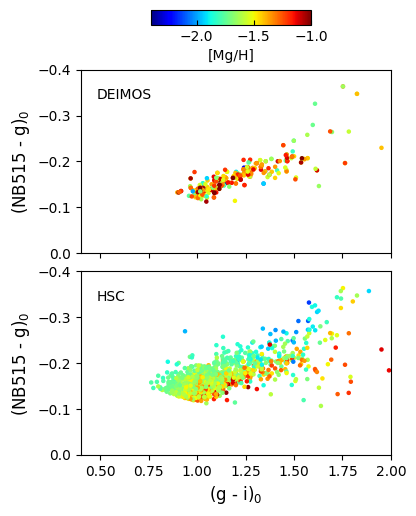

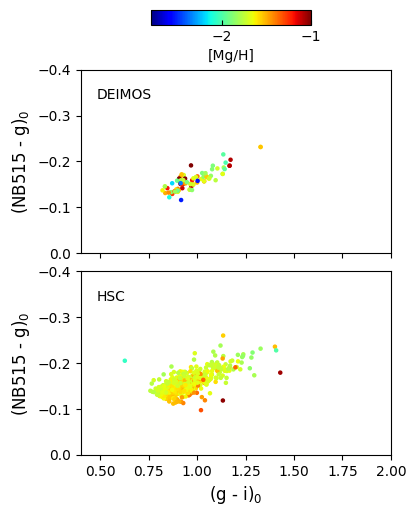

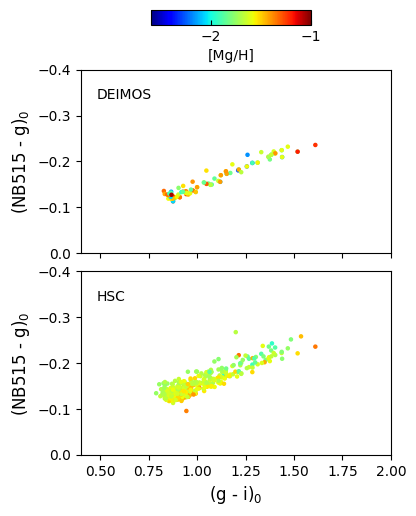

In [57]:
# Fornax
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'] - fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'] - hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/H]', size=10)
plt.savefig('ccd_deimos_hsc_mgh_Fornax.png', bbox_inches='tight')


# Sculptor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.4 ; vmax = -1
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'] - scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'] - hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/H]', size=10)
plt.savefig('ccd_deimos_hsc_mgh_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.8 ; vmax = -1
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'] - umi_mag['Mg0'], marker='o', s=s, c=umi_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'] - hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/H]', size=10)
plt.savefig('ccd_deimos_hsc_mgh_Ursaminor.png', bbox_inches='tight')


# Draco
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.6 ; vmax = -1
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'] - dra_mag['Mg0'], marker='o', s=s, c=dra_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'] - hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/H]', size=10)
plt.savefig('ccd_deimos_hsc_mgh_Draco.png', bbox_inches='tight')

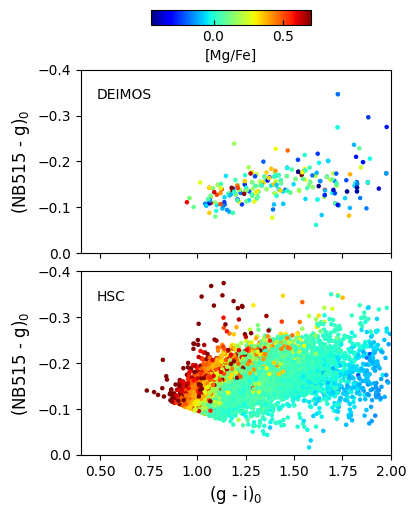

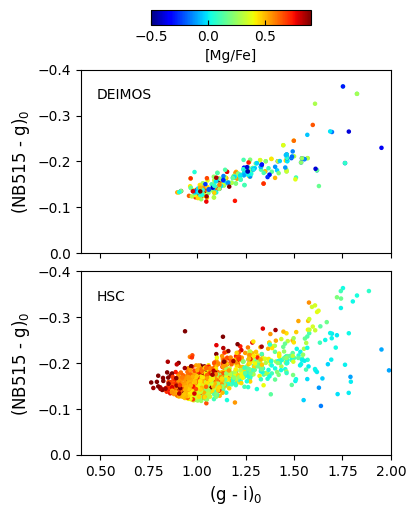

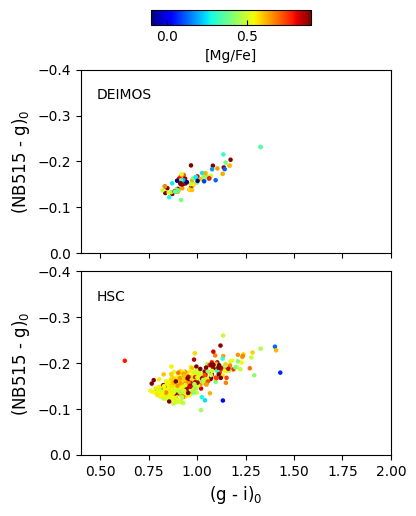

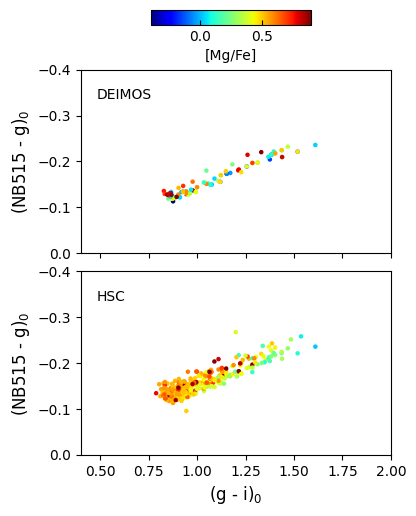

In [58]:
# Fornax
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -0.45 ; vmax = 0.7
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'] - fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'] - hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/Fe]', size=10)
plt.savefig('ccd_deimos_hsc_mgfe_Fornax.png', bbox_inches='tight')


# Sculptor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -0.5 ; vmax = 0.9
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'] - scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'] - hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/Fe]', size=10)
plt.savefig('ccd_deimos_hsc_mgfe_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -0.1 ; vmax = 0.9
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'] - umi_mag['Mg0'], marker='o', s=s, c=umi_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'] - hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/Fe]', size=10)
plt.savefig('ccd_deimos_hsc_mgfe_Ursaminor.png', bbox_inches='tight')


# Draco
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -0.4 ; vmax = 0.9
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'] - dra_mag['Mg0'], marker='o', s=s, c=dra_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'] - hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/Fe]', size=10)
plt.savefig('ccd_deimos_hsc_mgfe_Draco.png', bbox_inches='tight')